# Laboratorio 1

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/andonyns/air-quality/blob/main/main.ipynb)

# 1. Generalidades

A continuación se hace un análisis exploratorio de los datos de [OpenAQ](https://openaq.org/), con el fin de obtener conclusiones y recomendaciones respecto a la contaminación del aire en 6 países, para 6 parámetros de contaminación en específico.



# 2. Preparar el ambiente y las utilidades

## 2.a Instalar dependencias en google colab

In [8]:
%pip install -q python-dotenv matplotlib numpy pandas requests seaborn cartopy

## 2.b ¿Ejecutando localmente? Instala las dependencias con uv.

Clona el repositorio [https://github.com/andonyns/air-quality/tree/main](https://github.com/andonyns/air-quality/tree/main) y luego, dentro del directorio, ejecuta el siguiente comando:
```bash
pip install uv
```
Luego ejecuta el siguiente comando:
```bash
uv sync
```
Después, abre el cuaderno en Visual Studio Code o Jupyter Notebook y selecciona como kernel el entorno virtual creado por uv dentro del directorio actual.

# 2.c Importar bibliotecas

In [363]:
# For API requests
import requests
from urllib.parse import urljoin

# For env
import os
from dotenv import load_dotenv

try:
    import google.colab
    from google.colab import userdata
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# For data manipulation
from pprint import pprint
import pandas as pd
import pickle as pkl
import numpy as np
from scipy.stats import gmean
from sklearn.preprocessing import MinMaxScaler

import time
import logging
import sys

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.ndimage import gaussian_filter
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.lines as mlines

## 2.d Funciones de ayuda

In [10]:
def set_color(text: str, color: str = "green") -> str:
    """Set the color of the text using ANSI escape codes.

    Parameters
    ----------
    text : str
        The text to be colored.
    color : str, optional
        The color to apply to the text. Available options are:
        'green', 'yellow', 'red', 'blue', and 'orange'.
        Default is 'green'.

    Returns
    -------
    str
        The text with the specified ANSI color codes applied.
    """
    colors: Dict[str, str] = {
        "green": "\033[32m",
        "yellow": "\033[33m",
        "red": "\033[31m",
        "blue": "\033[34m",
        "orange": "\033[38;5;214m",
        "reset": "\033[0m",
    }
    return f"{colors[color]}{text}{colors['reset']}"


class StdOutLogger():
    """A custom logger that outputs to stdout with colored messages."""

    def __init__(self) -> None:
        """Initialize the StdOutLogger."""
        self.logger = logging.getLogger("Logger")
        self.logger.setLevel(logging.INFO)

        # Avoid duplicate handlers
        if not self.logger.hasHandlers():
            handler = logging.StreamHandler(sys.stdout)
            handler.setLevel(logging.INFO)
            formatter = logging.Formatter(
                "%(asctime)s - %(name)s - %(levelname)s - %(message)s",
                datefmt="%Y-%m-%d %H:%M:%S"
            )
            handler.setFormatter(formatter)
            self.logger.addHandler(handler)

    def info(self, message: str) -> None:
        """Log an info-level message.

        Parameters
        ----------
        message : str
            The message to log.
        """
        self.logger.info(message)

    def highlight(self, message: str) -> None:
        """Log a highlighted message in blue.

        Parameters
        ----------
        message : str
            The message to log.
        """
        self.logger.info(set_color(message, "blue"))

    def success(self, message: str) -> None:
        """Log an info-level success message in green.

        Parameters
        ----------
        message : str
            The success message to log.
        """
        self.logger.info(set_color(message, "green"))

    def warning(self, message: str) -> None:
        """Log a warning-level message in orange.

        Parameters
        ----------
        message : str
            The warning message to log.
        """
        self.logger.warning(set_color(message, "orange"))

    def critical(self, message: str) -> None:
        """Log a critical-level message in red.

        Parameters
        ----------
        message : str
            The critical message to log.
        """
        self.logger.critical(set_color(message, "red"))

    def error(self, message: str) -> None:
        """Log a error-level message in red.

        Parameters
        ----------
        message : str
            The critical message to log.
        """
        self.logger.critical(set_color(message, "red"))

Instanciamos un logger y cargamos las variables de ambiente para obtener API_KEY.

In [11]:
logger = StdOutLogger()
load_dotenv()

False

## 2.e Constantes

In [12]:
DATA_DIR = "data"
if not os.path.isdir(DATA_DIR):
    os.mkdir(DATA_DIR)

BASE_API_URL = "https://api.openaq.org/v3/"

if IN_COLAB:
  HEADERS = { "X-API-Key": userdata.get("API_KEY") }
else:
  HEADERS = { "X-API-Key": os.getenv("API_KEY")}

LOCATIONS_ENDPOINT = urljoin(BASE_API_URL, "locations/{location_id}")
MEASUREMENTS_ENDPOINT = urljoin(BASE_API_URL, "sensors/{sensor_id}/measurements")

## 2.f Cliente básico para obtener datos de OpenAQ

Ahora, creamos un cliente básico de OpenA! que haga las solicitudes a los endpoints correspondientes, y obtenga los datos para las localizaciones.

In [190]:
class OpenAQClient:
    """A static client for interacting with the OpenAQ API."""

    _base_url: str = BASE_API_URL
    _headers: dict = {"X-API-Key": os.getenv("API_KEY")}
    _logger: logging.Logger = logger

    @staticmethod
    def set_config(
        base_api_url: str = BASE_API_URL,
        api_key: str | None = None,
        logger: logging.Logger | None = None,
    ) -> None:
        """Configure the OpenAQClient.

        This method sets the base URL, API key, and logger for all
        subsequent requests.  It's a class method, so it's called on
        the class itself (e.g., OpenAQClient.set_config(...)).

        Parameters
        ----------
        base_api_url : str, optional
            The base URL for the OpenAQ API.  Default is the module-level
            BASE_API_URL.
        api_key : str, optional
            The API key for OpenAQ. If None, it will try to get it from
            the environment variable "API_KEY". Default is None.
        logger : logging.Logger, optional
            The logger to use.  Default is the module-level logger.
        """
        OpenAQClient._base_url = base_api_url
        OpenAQClient._headers = {"X-API-Key": api_key or os.getenv("API_KEY") or userdata.get("API_KEY")}
        OpenAQClient._logger = logger or logging.getLogger(__name__)

    @staticmethod
    def _fetch_data(
        endpoint: str,
        parameters: dict | None = None,
        query_parameters: dict | None = None,
        verbose: bool = False,
    ) -> requests.Response:
        """Fetch data from a given API endpoint.

        This is a static method, so it's called on the class
        (e.g., OpenAQClient._fetch_data(...)).

        Parameters
        ----------
        endpoint : str
            The specific endpoint URL (relative to the base URL).
        parameters : dict of str to any, optional
            Path parameters to format the endpoint URL.
        query_parameters : dict of str to any, optional
            Query parameters to append to the URL.
        verbose : bool, optional
            If True, print the response headers.

        Returns
        -------
        requests.Response
            The raw requests.Response object.

        Raises
        ------
        Exception
            If the HTTP request returns a status code other than 200.
        """
        url = urljoin(OpenAQClient._base_url, endpoint)

        if parameters:
            url = url.format(**parameters)

        if query_parameters:
            url += "?" + "&".join(f"{k}={v}" for k, v in query_parameters.items())

        response = requests.get(url=url, headers=OpenAQClient._headers)

        if response.status_code != 200:
            raise Exception(
                f"Request failed with status: {response.status_code}. Reason: {response.text}"
            )

        if verbose:
            OpenAQClient._logger.info(response.headers)

        return response

    @staticmethod
    def fetch_location_sensors_data(
        location_id: int,
        locations_endpoint: str = "locations/{location_id}",
        measures_endpoint: str = "sensors/{sensor_id}/measurements"
    ) -> dict:
        """Fetch sensor data for a specific location.

        This is a static method, so it's called on the class.

        Parameters
        ----------
        location_id : int
            The ID of the location.

        Returns
        -------
        dict
            A dictionary where keys are sensor IDs and values are lists of
            measurement data pages.
        """
        OpenAQClient._logger.info(f"Fetching data for location ID: {location_id}...")
        rate_limit_remaining = None
        rate_limit_reset = None

        try:
            if rate_limit_remaining == "1" and rate_limit_reset is not None:
                OpenAQClient._logger.warning(
                    f"Reached rate limit for location {location_id}. Waiting for {rate_limit_reset} seconds."
                )
                time.sleep(int(rate_limit_reset))

            location_response = OpenAQClient._fetch_data(
                endpoint=locations_endpoint,
                parameters={"location_id": location_id}
            )
            location_data = location_response.json()
            OpenAQClient._logger.success(
                f"Finished fetching location data for ID: {location_id}"
            )
        except Exception as e:
            OpenAQClient._logger.critical(
                f"Error fetching location data for ID {location_id}: {e}"
            )
            return {}

        sensors_data: dict = {}
        sensors = location_data["results"][0].get("sensors", [])

        for i, sensor in enumerate(sensors):
            sensor_id = sensor["id"]
            sensors_data[sensor_id] = []
            query_params: dict = {"limit": 1000, "page": 1}
            OpenAQClient._logger.info(
                f"Processing sensor ID: {sensor_id} (sensor {i + 1}/{len(sensors)})"
            )

            while True:
                try:

                    measurements_response = OpenAQClient._fetch_data(
                        endpoint=measures_endpoint,
                        parameters={"sensor_id": sensor_id},
                        query_parameters=query_params,
                    )
                    measurements_data = measurements_response.json()
                    OpenAQClient._logger.info(
                        f"Processing sensor ID {sensor_id}, page {measurements_data['meta']['page']}"
                    )
                    OpenAQClient._logger.warning(
                        f"Remaining requests: {measurements_response.headers.get('X-Ratelimit-Remaining', 'N/A')}"
                    )
                    sensors_data[sensor_id].append(measurements_data)



                    rate_limit_remaining = measurements_response.headers.get(
                        "X-Ratelimit-Remaining"
                    )
                    rate_limit_reset = measurements_response.headers.get(
                        "X-Ratelimit-Reset"
                    )
                    if rate_limit_remaining == "1" and rate_limit_reset is not None:
                        OpenAQClient._logger.warning(
                            f"Reached rate limit for sensor {sensor_id}. Waiting for {rate_limit_reset} seconds."
                        )
                        time.sleep(int(rate_limit_reset))
                    if len(measurements_data["results"]) < 1000:
                        break

                    query_params["page"] += 1
                except Exception as e:
                    OpenAQClient._logger.error(
                        f"Error fetching measurements for sensor ID {sensor_id}: {e}"
                    )
                    break

            OpenAQClient._logger.success(f"Finished processing sensor ID: {sensor_id}")

        OpenAQClient._logger.success(
            f"Finished processing all sensors for location ID: {location_id}"
        )
        return sensors_data

Establecemos una configuración inicial para el cliente:

In [194]:
OpenAQClient.set_config(
    base_api_url=BASE_API_URL,
    api_key=os.getenv("API_KEY"),
    logger=logger,
)

### Ejemplo de CR

Podemos obtener los datos de una localización llamando a la función y accediendo al endpoint de las localizaciones. De antemano, se buscó el ID de la localización existente en [Explore the data](https://explore.openaq.org/#1.2/20/40). Así se usa esto como parámetro para obtener la información de la localización.

In [22]:
# Costa Rica example
cr_location_id = 3070644

cr_location_data = OpenAQClient._fetch_data(
    endpoint=LOCATIONS_ENDPOINT,
    parameters={"location_id": cr_location_id},
).json()
pprint(cr_location_data)

{'meta': {'found': 1,
          'limit': 100,
          'name': 'openaq-api',
          'page': 1,
          'website': '/'},
 'results': [{'bounds': [-84.0417, 9.938, -84.0417, 9.938],
              'coordinates': {'latitude': 9.938, 'longitude': -84.0417},
              'country': {'code': 'CR', 'id': 29, 'name': 'Costa Rica'},
              'datetimeFirst': {'local': '2024-09-19T14:01:34-06:00',
                                'utc': '2024-09-19T20:01:34Z'},
              'datetimeLast': {'local': '2025-04-27T09:53:41-06:00',
                               'utc': '2025-04-27T15:53:41Z'},
              'distance': None,
              'id': 3070644,
              'instruments': [{'id': 4, 'name': 'Clarity Sensor'}],
              'isMobile': False,
              'isMonitor': False,
              'licenses': [{'attribution': {'name': 'Clarity', 'url': None},
                            'dateFrom': '2021-10-20',
                            'dateTo': None,
                            'id

Específicamente, este endpoint extrae, entre otras cosas, la información de los sensores que toman datos allí. Con esta información es posible obtener la información de los datos que han medido los sensores a través del tiempo.

En este caso, y a modo de ejemplo, vamos a obtener la información del primer sensor de Costa Rica.

In [23]:
# Get the first sensor
sensor = cr_location_data["results"][0]["sensors"][0]
not_finished = True
query_params = {"limit": 1000, "page": 1}

while not_finished:
    sensor_id = sensor["id"]
    sensor_data = OpenAQClient._fetch_data(
        endpoint=MEASUREMENTS_ENDPOINT,
        parameters={"sensor_id": sensor_id},
        query_parameters=query_params,
    ).json()
    if len(sensor_data["results"]) < 1000:
        print(f"last page: {sensor_data['meta']['page']}")
        not_finished = False

    else:
        query_params["page"] += 1

print(f"Total pages: {query_params['page']}")

last page: 13
Total pages: 13


Agrupando las mediciones por día, se obtiene una granularidad decente para el análisis de los datos, pues muchos países no tiene una única página de datos como Costa Rica, si no que tiene muchísimas páginas más.

Vamos a hacer una función para obtener la información de todas las páginas de medidas que arroja el endpoint.

### Obtención de datos de todas las localizaciones

Por comodidad, también podemos hacer una clase localización, que guarde datos básicos de ella y además los datos de sus sensores.

In [191]:
class Location:
    def __init__(
        self,
        country: str,
        name: str,
        id: int,
        sensors_data: dict = None,
    ) -> None:
        self.country: str = country
        self.name: str = name
        self.id: int = id
        self.sensors_data: dict = sensors_data
        self.coordinates: tuple[float, float] = None
        self.file_path: str = f"{DATA_DIR}/{country}_{name}/{country}_{name}"

    def pull_location_data(self):
        location_data = OpenAQClient._fetch_data(
            endpoint="locations/{location_id}",
            parameters={"location_id": location.id},
        ).json()

        self.coordinates = location_data['results'][0]['coordinates']


    def pull_sensors_data(self, grouped_by: str = None) -> None:
        if grouped_by is None:
          self.sensors_data = OpenAQClient.fetch_location_sensors_data(self.id)
        else:
          self.sensors_data = OpenAQClient.fetch_location_sensors_data(
              self.id,
              measures_endpoint="sensors/{sensor_id}/measurements/" + grouped_by
          )

    @staticmethod
    def save(location: "Location") -> None:
        if not os.path.isdir(DATA_DIR + f"/{location.country}_{location.name}"):
            os.mkdir(DATA_DIR + f"/{location.country}_{location.name}")

        with open(f"{location.file_path}.pkl", "wb") as f:
            pkl.dump(location, f)

    @staticmethod
    def load(location: "Location") -> "Location":
        with open(f"{location.file_path}.pkl", "rb") as f:
            location = pkl.load(f)

        return location

In [135]:
locations = [
    Location(
        country="Costa Rica",
        name="NASA GSFC Rutgers Calib. N13",
        id=3070644,
    ),
    Location(
        country="Reino Unido",
        name="UAL Creative Computing Institute, Greencoat Building",
        id=1462792,
    ),
    Location(
        country="Vietnam",
        name="CMT8",
        id=3276359,
    ),
    Location(
        country="Ghana",
        name="Afri-SET",
        id=2453500,
    ),
    Location(
        country="Mumbai",
        name="Mahape, Navi Mumbai",
        id=6943,
    ),
    Location(
        country="Estados Unidos, California",
        name="Puente Plaza",
        id=3046642,
    ),
]

Los países y localizaciones seleccionados para el análisis son los siguientes:

In [192]:
locations = [
    Location(
        country="Costa Rica",
        name="NASA GSFC Rutgers Calib. N13",
        id=3070644,
    ),
    Location(
        country="China",
        name="Hong Kong, North",
        id=233335
    ),
    Location(
        country="Italia",
        name="Marche, Genga -Parco Gola della Rossa",
        id=8232
    ),
    Location(
        country="España",
        name="Madrid, Villa del Prado",
        id=2162432
    ),
    Location(
        country="Mumbai",
        name="Mahape, Navi Mumbai",
        id=6943,
    ),
    Location(
        country="Perú",
        name="Ayacucho, Pariachi",
        id=2143681,
    ),
]

Además, se quieren medir estos parámetros, que son mencionados por documentos oficiales de la [EPA](https://www.epa.gov/). Las definiciones fueron tomadas de la [Ley de Aire Limpio](https://www.epa.gov/criteria-air-pollutants/information-pollutant):

1. PM (Partículas Materiales): Estas partículas vienen en muchos tamaños y formas y pueden estar compuestas de cientos de químicos diferentes. Algunas se emiten directamente de una fuente, como sitios de construcción, caminos sin pavimentar, campos, chimeneas o incendios. La mayoría de las partículas se forman en la atmósfera como resultado de reacciones complejas de químicos como el dióxido de azufre y los óxidos de nitrógeno, que son contaminantes emitidos por plantas de energía, industrias y automóviles.

   - PM₂.₅ (Partículas Materiales de 2.5 micrómetros o más pequeñas):
     partículas inhalables finas, con diámetros que generalmente son de 2.5 micrómetros o más pequeños.

   - PM₁₀ (Partículas Materiales de 10 micrómetros o más pequeñas):
     partículas inhalables, con diámetros que generalmente son de 10 micrómetros o más pequeños.

2. O₃ (Ozono):
   El ozono troposférico, o a nivel del suelo, no se emite directamente al aire, sino que se crea por reacciones químicas entre los óxidos de nitrógeno (NOx) y los compuestos orgánicos volátiles (COV). Esto sucede cuando los contaminantes emitidos por automóviles, plantas de energía, calderas industriales, refinerías, plantas químicas y otras fuentes reaccionan químicamente en presencia de la luz solar.

3. NO₂ (Dióxido de Nitrógeno):
   El dióxido de nitrógeno (NO₂) es uno de un grupo de gases altamente reactivos conocidos como óxidos de nitrógeno (NOx). Otros óxidos de nitrógeno incluyen el ácido nitroso y el ácido nítrico. El NO₂ se utiliza como indicador del grupo más grande de óxidos de nitrógeno. El NO₂ llega principalmente al aire por la quema de combustible. El NO₂ se forma a partir de las emisiones de automóviles, camiones y autobuses, plantas de energía y equipos todoterreno.

4. SO₂ (Dióxido de Azufre):
   El SO₂ es el componente de mayor preocupación y se utiliza como indicador del grupo más grande de óxidos de azufre gaseosos (SOx). Otros SOx gaseosos (como el SO₃) se encuentran en la atmósfera en concentraciones mucho más bajas que el SO₂. La mayor fuente de SO₂ en la atmósfera es la quema de combustibles fósiles por parte de las centrales eléctricas y otras instalaciones industriales. Las fuentes más pequeñas de emisiones de SO₂ incluyen: procesos industriales como la extracción de metal de los minerales; fuentes naturales como los volcanes; y locomotoras, barcos y otros vehículos y equipos pesados que queman combustible con un alto contenido de azufre.

5. CO (Monóxido de Carbono):
   El CO es un gas incoloro e inodoro que puede ser dañino cuando se inhala en grandes cantidades. El CO se libera cuando se quema algo. Las mayores fuentes de CO en el aire exterior son los automóviles, camiones y otros vehículos o maquinaria que queman combustibles fósiles. Una variedad de artículos en su hogar, como calentadores de ambiente de queroseno y gas sin ventilación, chimeneas y hornos con fugas, y estufas de gas también liberan CO y pueden afectar la calidad del aire en interiores.

In [374]:
selected_parameters = ['pm25 µg/m³', 'co µg/m³', 'no2 µg/m³', 'o3 µg/m³', 'pm10 µg/m³', 'so2 µg/m³']

Vamos a obtener los datos agrupados por día para cada localización. Sería posible obtener cada una de las mediciones individuales, sin embargo, el endpoint no está optimizado para que le soliciten tantas páginas. Mientras más alto es el número de página que se le solicita, más lenta va a ser la respuesta. El servidor finaliza la solicitud si tarda demasiado. Ejecute esta celda para ver el comportamiento descrito:

In [ ]:
# For every location, save all info
for location in locations:
    # No grouping
    location.pull_sensors_data(grouped_by=None)
    Location.save(location)

    del location.sensors_data

    logger.success(f"Saved data for location {location.name}")

INFO:Logger:Fetching data for location ID: 3070644...
INFO:Logger:Finished fetching location data for ID: 3070644
INFO:Logger:Processing sensor ID: 10669679 (sensor 1/1)
INFO:Logger:Processing sensor ID 10669679, page 1
INFO:Logger:Processing sensor ID 10669679, page 2
INFO:Logger:Processing sensor ID 10669679, page 3
INFO:Logger:Processing sensor ID 10669679, page 4
INFO:Logger:Processing sensor ID 10669679, page 5
INFO:Logger:Processing sensor ID 10669679, page 6
INFO:Logger:Processing sensor ID 10669679, page 7
INFO:Logger:Processing sensor ID 10669679, page 8
INFO:Logger:Processing sensor ID 10669679, page 9
INFO:Logger:Processing sensor ID 10669679, page 10
INFO:Logger:Processing sensor ID 10669679, page 11
INFO:Logger:Processing sensor ID 10669679, page 12
INFO:Logger:Processing sensor ID 10669679, page 13
INFO:Logger:Finished processing sensor ID: 10669679
INFO:Logger:Finished processing all sensors for location ID: 3070644
INFO:Logger:Saved data for location NASA GSFC Rutgers C

Varios senores muestra errores al intentar conseguir los datos, pues las solicitudes tardaron demasiado. Por lo tanto, **se prefirió hacer las solicitudes agrupadas por día**, que todavía son suficientemente representativas.

In [195]:
# For every location, save all info
for location in locations:
    # Set daily group
    location.pull_location_data()
    location.pull_sensors_data(grouped_by="daily")
    Location.save(location)

    del location.sensors_data

    logger.success(f"Saved data for location {location.name}")

INFO:Logger:Fetching data for location ID: 3070644...
INFO:Logger:Finished fetching location data for ID: 3070644
INFO:Logger:Processing sensor ID: 10669679 (sensor 1/1)
INFO:Logger:Processing sensor ID 10669679, page 1
INFO:Logger:Finished processing sensor ID: 10669679
INFO:Logger:Finished processing all sensors for location ID: 3070644
INFO:Logger:Saved data for location NASA GSFC Rutgers Calib. N13
INFO:Logger:Fetching data for location ID: 233335...
INFO:Logger:Finished fetching location data for ID: 233335
INFO:Logger:Processing sensor ID: 1342527 (sensor 1/6)
INFO:Logger:Processing sensor ID 1342527, page 1
INFO:Logger:Processing sensor ID 1342527, page 2
INFO:Logger:Finished processing sensor ID: 1342527
INFO:Logger:Processing sensor ID: 1342531 (sensor 2/6)
INFO:Logger:Processing sensor ID 1342531, page 1
INFO:Logger:Processing sensor ID 1342531, page 2
INFO:Logger:Finished processing sensor ID: 1342531
INFO:Logger:Processing sensor ID: 1342530 (sensor 3/6)
INFO:Logger:Process

¡Listo! Ya obtuvimos los datos de cada localización y sensor.


# 3. Tareas de limpieza y transformación:

Se deben realizar las tareas de limpieza y transformación necesarias para poder hacer un comparativo de la evolución de los diferentes indicadores de la calidad del aire en Costa Rica y las otras ciudades.


Primero, vamos a cargar los datos recientemente obtenidos con el cliente de OpenAQ.

In [196]:
# Load the data
locations = [Location.load(location) for location in locations]

## 3.a Paso a csv

Primero, vamos a eliminar los datos que no interesan y quedarnos con los que son relevantes para hacer análisis

In [197]:
def location_to_pd(location_data: Location) -> pd.DataFrame:
    """Convert location measurement data into a pandas DataFrame.

    Extracts individual sensor measurements from the nested structure
    within a Location object (typically obtained from an API client like
    OpenAQClient) and organizes them into a flat DataFrame format.

    Parameters
    ----------
    location_data : Location
        An object representing a specific location. It is expected to have
        attributes: `id` (int), `name` (str), `country` (str), and
        `sensors_data` (dict). The `sensors_data` attribute should be a
        dictionary mapping sensor IDs to lists of page results. Each page
        is expected to be a dictionary containing a 'results' key, which
        maps to a list of individual measurement dictionaries.

    Returns
    -------
    pd.DataFrame
        A DataFrame where each row represents a single measurement period
        for a specific sensor at the given location. Columns include:
        'location_id', 'location_name', 'sensor_id', 'from_date',
        'to_date', 'parameter_name', 'parameter_units', 'value',
        'aggregated_count', 'summary_avg', 'summary_max', 'summary_median',
        'summary_min', 'summary_q02', 'summary_q25', 'summary_q75',
        'summary_q98', 'summary_sd'.

    Notes
    -----
    Assumes the nested structure of `location_data.sensors_data` where
    measurements are contained within pages under the 'results' key.
    The structure typically originates from paginated API responses.

    """
    rows = []
    location_name = location_data.name
    country_name = location.country

    for sensor_id, sensor_pages in location_data.sensors_data.items():
        for page in sensor_pages:
            measurements = page.get("results", [])

            for measurement in measurements:
                period = measurement.get("period", {})
                datetime_from = period.get("datetimeFrom", {})
                datetime_to = period.get("datetimeTo", {})
                parameter = measurement.get("parameter", {})
                coverage = measurement.get("coverage", {})
                summary = measurement.get("summary", {})

                rows.append(
                    [
                        location_data.id,
                        country_name,
                        location_name,
                        sensor_id,
                        datetime_from.get("utc"),
                        datetime_to.get("utc"),
                        parameter.get("name") + " " + parameter.get("units"),
                        parameter.get("units"),
                        measurement.get("value"),
                        coverage.get("observedCount"),
                        summary.get("avg"),
                        summary.get("max"),
                        summary.get("median"),
                        summary.get("min"),
                        summary.get("q02"),
                        summary.get("q25"),
                        summary.get("q75"),
                        summary.get("q98"),
                        summary.get("sd"),
                    ]
                )

    columns = [
        "location_id",
        "country_name",
        "location_name",
        "sensor_id",
        "from_date",
        "to_date",
        "parameter_name",
        "parameter_units",
        "value",
        "aggregated_count",
        "summary_avg",
        "summary_max",
        "summary_median",
        "summary_min",
        "summary_q02",
        "summary_q25",
        "summary_q75",
        "summary_q98",
        "summary_sd",
    ]

    return pd.DataFrame(rows, columns=columns)

In [198]:
for location in locations:
    df = location_to_pd(location)
    df.to_csv(f"{location.file_path}.csv", index=False)

In [199]:
locations_dfs = [pd.read_csv(f"{location.file_path}.csv") for location in locations]

## 3.b Descripción de los datos

Veamos si hay valores nulos en alguno de los data frames.

In [200]:
for df, location in zip(locations_dfs, locations):
    logger.info(f"Location: {location.country} {location.name}")
    logger.info(f"DataFrame null values: {df.isnull().sum()}")

INFO:Logger:Location: Costa Rica NASA GSFC Rutgers Calib. N13
INFO:Logger:DataFrame null values: location_id         0
country_name        0
location_name       0
sensor_id           0
from_date           0
to_date             0
parameter_name      0
parameter_units     0
value               0
aggregated_count    0
summary_avg         0
summary_max         0
summary_median      0
summary_min         0
summary_q02         0
summary_q25         0
summary_q75         0
summary_q98         0
summary_sd          0
dtype: int64
INFO:Logger:Location: China Hong Kong, North
INFO:Logger:DataFrame null values: location_id          0
country_name         0
location_name        0
sensor_id            0
from_date            0
to_date              0
parameter_name       0
parameter_units      0
value                0
aggregated_count     0
summary_avg          0
summary_max          0
summary_median       0
summary_min          0
summary_q02          0
summary_q25          0
summary_q75          0
s

Aparentemente hay valores nulos en el campo de "sd". Estos son datos en donde el proceso de agregado solo tenía un elemento, por lo que no hay una desviación estándar para los datos de ese día. Esto no es preocupante, pero se deben cambiar estos datos a un 0.

In [201]:
for df in locations_dfs:
    df["summary_sd"] = df["summary_sd"].replace({np.nan: 0})

Verifiquemos nuevamente la cantidad de nulos.

In [202]:
for df, location in zip(locations_dfs, locations):
    logger.info(f"Location: {location.country} {location.name}")
    logger.info(f"DataFrame null values: \n{df.isnull().sum()}")

INFO:Logger:Location: Costa Rica NASA GSFC Rutgers Calib. N13
INFO:Logger:DataFrame null values: 
location_id         0
country_name        0
location_name       0
sensor_id           0
from_date           0
to_date             0
parameter_name      0
parameter_units     0
value               0
aggregated_count    0
summary_avg         0
summary_max         0
summary_median      0
summary_min         0
summary_q02         0
summary_q25         0
summary_q75         0
summary_q98         0
summary_sd          0
dtype: int64
INFO:Logger:Location: China Hong Kong, North
INFO:Logger:DataFrame null values: 
location_id         0
country_name        0
location_name       0
sensor_id           0
from_date           0
to_date             0
parameter_name      0
parameter_units     0
value               0
aggregated_count    0
summary_avg         0
summary_max         0
summary_median      0
summary_min         0
summary_q02         0
summary_q25         0
summary_q75         0
summary_q98     

Hemos limpiado los datos y están listos para el análisis.

Además, seleccionamos únicamente los parámetros 'pm25 µg/m³', 'co µg/m³', 'no2 µg/m³', 'o3 µg/m³', 'pm10 µg/m³', 'so2 µg/m³', vamos a eliminar aquellos que no estén en la lista para cada localización.

In [237]:
for idx, df in enumerate(locations_dfs):
    # Filtrar según los parámetros permitidos
    df = df[df['parameter_name'].isin(selected_parameters)]
    locations_dfs[idx] = df

In [238]:
for df, location in zip(locations_dfs, locations):
    df.to_csv(f"{location.file_path}_cleaned.csv", index=False)


# 4. Análisis y comparación:

Se debe realizar un análisis EDA que incluya análisis univariable y multivariable.

Analizar las tendencias de los indicadores para las diferentes ciudades y hacer comparaciones entre diferentes países y ciudades.

Incluir posibles correlaciones entre las variables y parámetros de calidad del aire de cada país/ciudad.

Utilizar diferentes tipos de visualizaciones relevantes para el análisis.



## 4.a Localizaciones

Podemos visualizar las localizaciones.

In [239]:
# Get a colormap
cmap = plt.get_cmap('Set1')

# Create a list of colors based on the number of locations
colors = [cmap(i / len(locations)) for i in range(len(locations))]

locations_color_map = {}
for i, location in enumerate(locations):
  locations_color_map[location.country] = colors[i]

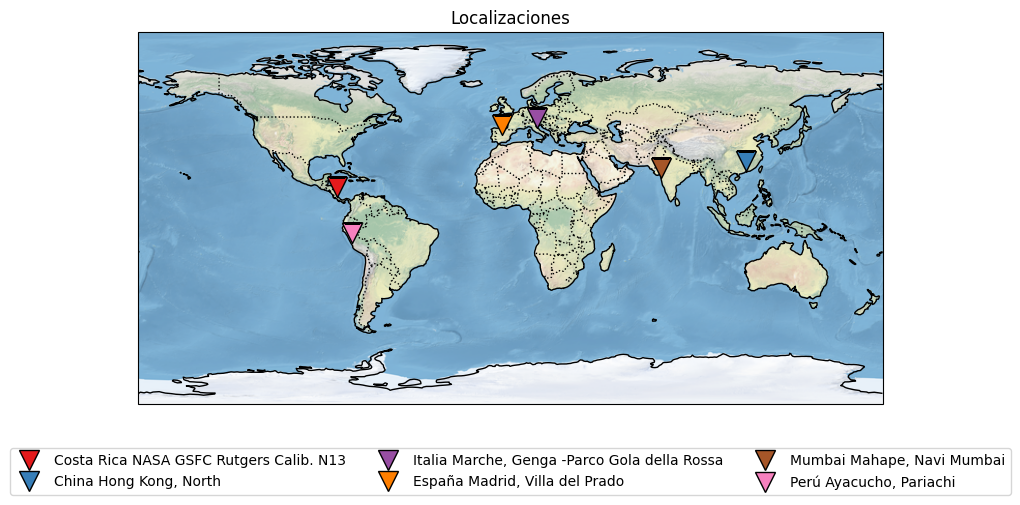

In [240]:
# Setup the map
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={'projection': ccrs.PlateCarree()}
)
ax.stock_img()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.coastlines()
# Plot each location on the map
for i, location in enumerate(locations):
    longitude = location.coordinates['longitude']
    # We add a little offset to move the triangle tip to point
    latitude = location.coordinates['latitude'] + 5

    color = locations_color_map[location.country]

    ax.plot(
        longitude,
        latitude,
        label=location.country + " " + location.name,
        color=color,
        marker='v',
        markeredgewidth=1,
        markeredgecolor='black',
        markersize=15,
        linestyle='None',
        transform=ccrs.PlateCarree()
    )

# Legend with colors
ax.legend(
    loc='upper center',
    fontsize=10,
    bbox_to_anchor=(0.5, -0.1),
    ncol=3
)
plt.title("Localizaciones")
plt.tight_layout()
plt.show()

## 4.b Análisis descriptivo

Veamos la cantidad de datos en cada localización.

In [241]:
data = []

for df, location in zip(locations_dfs, locations):
    data.append({
        "Pais": location.country,
        "Localizacion": location.name,
        "Datos": df.shape[0]
    })

data_df = pd.DataFrame(data)
data_df = data_df.sort_values(by="Datos", ascending=False)
data_df

Pais                           Localizacion  Datos
2      Italia  Marche, Genga -Parco Gola della Rossa   9040
1       China                       Hong Kong, North   7701
4      Mumbai                    Mahape, Navi Mumbai   5509
5        Perú                     Ayacucho, Pariachi   2292
3      España                Madrid, Villa del Prado   2006
0  Costa Rica           NASA GSFC Rutgers Calib. N13    204

<Figure size 1000x800 with 0 Axes>

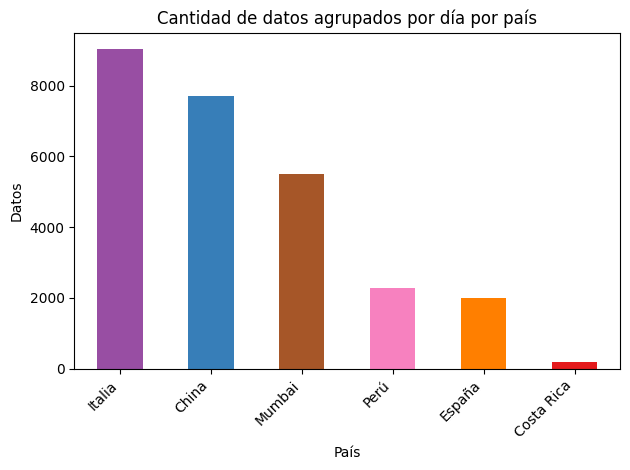

In [242]:
ordered_colors = [locations_color_map[country] for country in data_df['Pais'].tolist()]

# Create the bar plot
plt.figure(figsize=(10, 8))
ax = data_df.plot(
    kind='bar',
    x='Pais',
    y='Datos',
    color=ordered_colors,
    legend=False
)

# Rotate x-ticks
plt.xticks(rotation=45, ha='right')

plt.xlabel('País')
plt.ylabel('Datos')
plt.title('Cantidad de datos agrupados por día por país')

plt.tight_layout()
plt.show()

Mumbai es el país con más datos de todos, con una diferencia importante. Reino Unido y Ghana tienen una cantidad similar, y los que menos datos tienen son California, Vietnam y Costa Rica.

No obstante, hay que recordar que estos números son días completos y no mediciones individuales. Es decir, están agrupados por días. La cantidad real de datos recolectados en cada localización es la siguiente:

In [243]:
data = []

for df, location in zip(locations_dfs, locations):
    data.append({
        "Pais": location.country,
        "Localizacion": location.name,
        "Datos": df['aggregated_count'].sum()
    })

data_df = pd.DataFrame(data)
data_df = data_df.sort_values(by="Datos", ascending=False)
data_df

Pais                           Localizacion   Datos
4      Mumbai                    Mahape, Navi Mumbai  162377
1       China                       Hong Kong, North  161182
2      Italia  Marche, Genga -Parco Gola della Rossa  140878
5        Perú                     Ayacucho, Pariachi   51264
3      España                Madrid, Villa del Prado   28933
0  Costa Rica           NASA GSFC Rutgers Calib. N13   12677

<Figure size 1000x800 with 0 Axes>

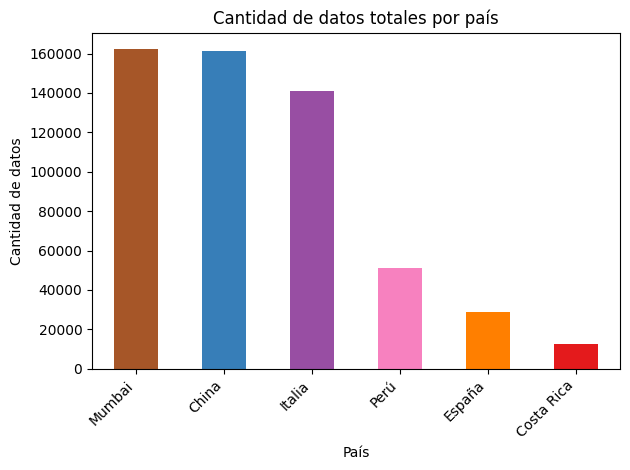

In [244]:
ordered_colors = [locations_color_map[country] for country in data_df['Pais'].tolist()]

# Create the bar plot
plt.figure(figsize=(10, 8))
ax = data_df.plot(
    kind='bar',
    x='Pais',
    y='Datos',
    color=ordered_colors,
    legend=False
)

# Rotate x-ticks
plt.xticks(rotation=45, ha='right')

plt.xlabel('País')
plt.ylabel('Cantidad de datos')
plt.title('Cantidad de datos totales por país')

plt.tight_layout()
plt.show()

Vemos que con los datos reales, la diferencia es todavía más grande.

Por último, podemos describir los datos numéricos en cada data frame.

In [245]:
for df, location in zip(locations_dfs, locations):
    logger.highlight(f"Location: {location.country} {location.name}")
    description = df.describe().to_string()

    logger.info(f"Description:\n{description}")

INFO:Logger:Location: Costa Rica NASA GSFC Rutgers Calib. N13
INFO:Logger:Description:
       location_id   sensor_id       value  aggregated_count  summary_avg  summary_max  summary_median  summary_min  summary_q02  summary_q25  summary_q75  summary_q98  summary_sd
count        204.0       204.0  204.000000        204.000000   204.000000   204.000000      204.000000   204.000000   204.000000   204.000000   204.000000   204.000000  204.000000
mean     3070644.0  10669679.0    6.078775         62.142157     6.078539     8.999412        5.928113     4.468922     4.568910     5.282672     6.731385     8.368207    1.078202
std            0.0         0.0    1.345131         14.582343     1.344680     3.137471        1.332099     0.771879     0.820606     1.113101     1.698608     2.533903    0.634922
min      3070644.0  10669679.0    4.010000          4.000000     4.005652     5.010000        3.890000     3.410000     3.420000     3.660000     4.270000     4.825600    0.105317
25%      3070

# Poner analisis del describe aca

In [373]:
pd.set_option('future.no_silent_downcasting', True)

parameter_location_map = {}
# Fill the dictionary with a check if the location has the parameter
for df, location in zip(locations_dfs, locations):
    location_name = f"{location.country}"
    parameters = df['parameter_name'].unique()

    for param in parameters:
        if param not in parameter_location_map:
            parameter_location_map[param] = {}
        parameter_location_map[param][location_name] = True

parameter_location_df = pd.DataFrame.from_dict(parameter_location_map, orient='index')
parameter_location_df = parameter_location_df.fillna(False)
parameter_location_df = parameter_location_df.replace({True: 'X', False: ''})
parameter_location_df = parameter_location_df.style.set_properties(**{
    'text-align': 'center'
})

print("Parámetros medidos por cada país")
parameter_location_df

Parámetros medidos por cada país


Para entender estos conceptos, veamos lo que indica la [EPA](https://www.epa.gov/). Las definiciones fueron tomadas de la [Ley de Aire Limpio](https://www.epa.gov/criteria-air-pollutants/information-pollutant):

1. PM (Partículas Materiales): Estas partículas vienen en muchos tamaños y formas y pueden estar compuestas de cientos de químicos diferentes. Algunas se emiten directamente de una fuente, como sitios de construcción, caminos sin pavimentar, campos, chimeneas o incendios. La mayoría de las partículas se forman en la atmósfera como resultado de reacciones complejas de químicos como el dióxido de azufre y los óxidos de nitrógeno, que son contaminantes emitidos por plantas de energía, industrias y automóviles.

   - PM₂.₅ (Partículas Materiales de 2.5 micrómetros o más pequeñas):
     partículas inhalables finas, con diámetros que generalmente son de 2.5 micrómetros o más pequeños.

   - PM₁₀ (Partículas Materiales de 10 micrómetros o más pequeñas):
     partículas inhalables, con diámetros que generalmente son de 10 micrómetros o más pequeños.

2. O₃ (Ozono):
   El ozono troposférico, o a nivel del suelo, no se emite directamente al aire, sino que se crea por reacciones químicas entre los óxidos de nitrógeno (NOx) y los compuestos orgánicos volátiles (COV). Esto sucede cuando los contaminantes emitidos por automóviles, plantas de energía, calderas industriales, refinerías, plantas químicas y otras fuentes reaccionan químicamente en presencia de la luz solar.

3. NO₂ (Dióxido de Nitrógeno):
   El dióxido de nitrógeno (NO₂) es uno de un grupo de gases altamente reactivos conocidos como óxidos de nitrógeno (NOx). Otros óxidos de nitrógeno incluyen el ácido nitroso y el ácido nítrico. El NO₂ se utiliza como indicador del grupo más grande de óxidos de nitrógeno. El NO₂ llega principalmente al aire por la quema de combustible. El NO₂ se forma a partir de las emisiones de automóviles, camiones y autobuses, plantas de energía y equipos todoterreno.

4. SO₂ (Dióxido de Azufre):
   El SO₂ es el componente de mayor preocupación y se utiliza como indicador del grupo más grande de óxidos de azufre gaseosos (SOx). Otros SOx gaseosos (como el SO₃) se encuentran en la atmósfera en concentraciones mucho más bajas que el SO₂. La mayor fuente de SO₂ en la atmósfera es la quema de combustibles fósiles por parte de las centrales eléctricas y otras instalaciones industriales. Las fuentes más pequeñas de emisiones de SO₂ incluyen: procesos industriales como la extracción de metal de los minerales; fuentes naturales como los volcanes; y locomotoras, barcos y otros vehículos y equipos pesados que queman combustible con un alto contenido de azufre.

5. CO (Monóxido de Carbono):
   El CO es un gas incoloro e inodoro que puede ser dañino cuando se inhala en grandes cantidades. El CO se libera cuando se quema algo. Las mayores fuentes de CO en el aire exterior son los automóviles, camiones y otros vehículos o maquinaria que queman combustibles fósiles. Una variedad de artículos en su hogar, como calentadores de ambiente de queroseno y gas sin ventilación, chimeneas y hornos con fugas, y estufas de gas también liberan CO y pueden afectar la calidad del aire en interiores.

## 4.c Análisis univariable

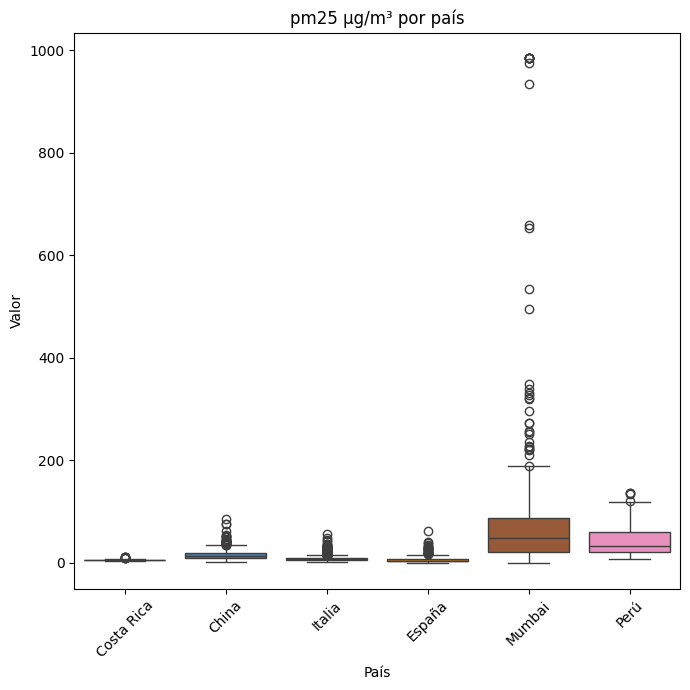

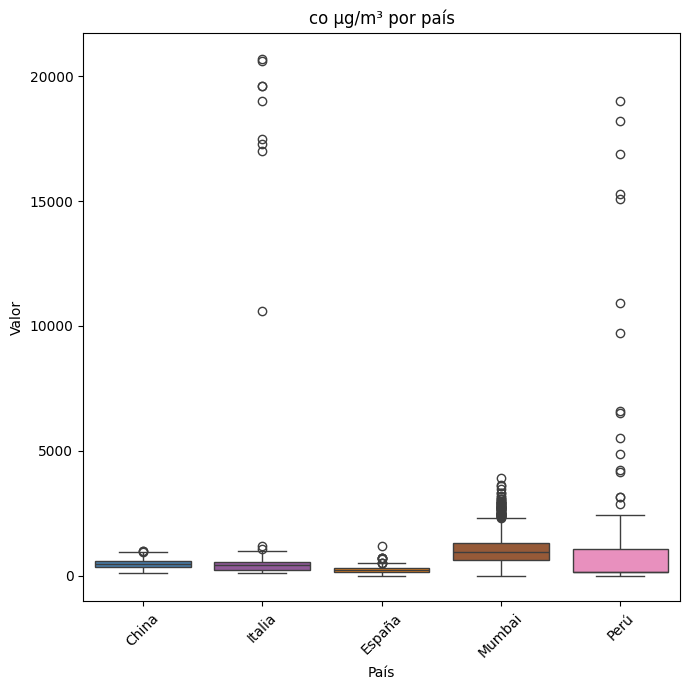

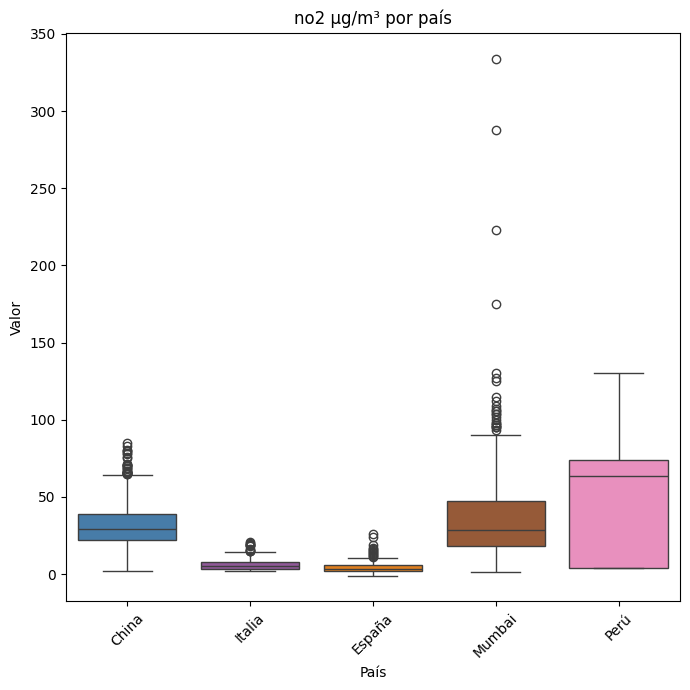

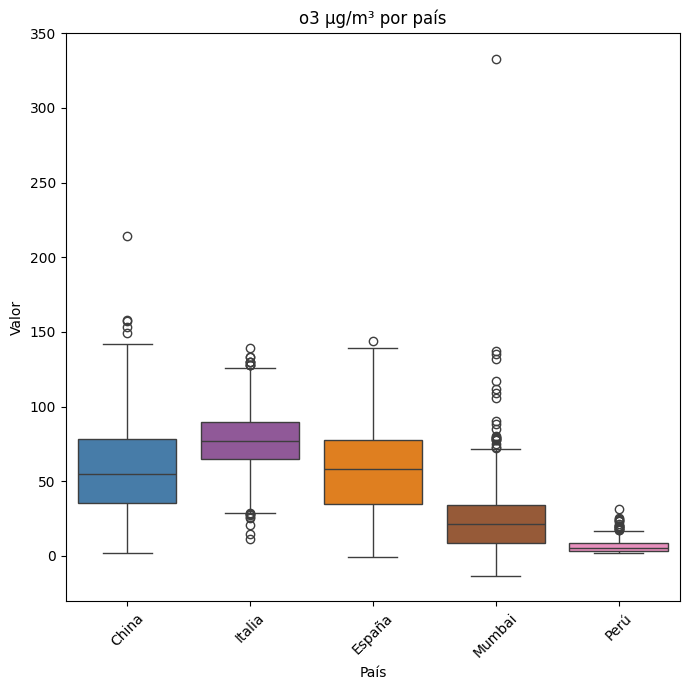

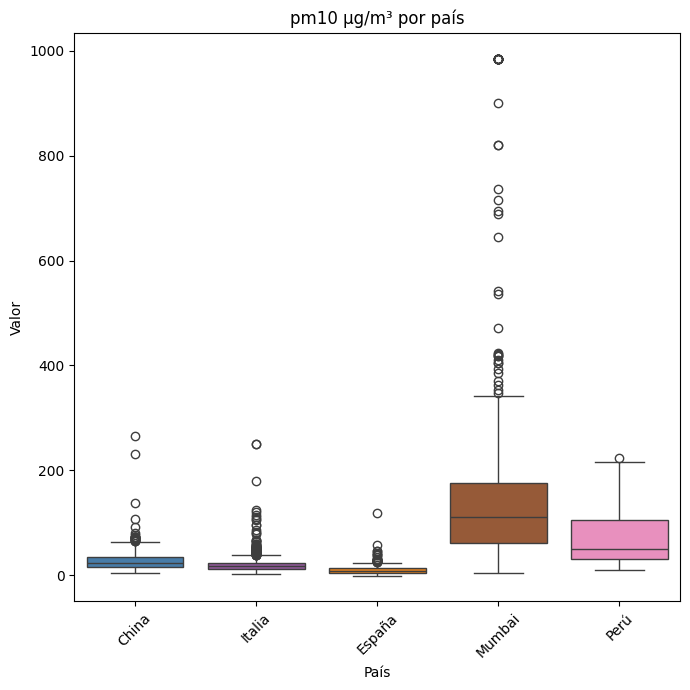

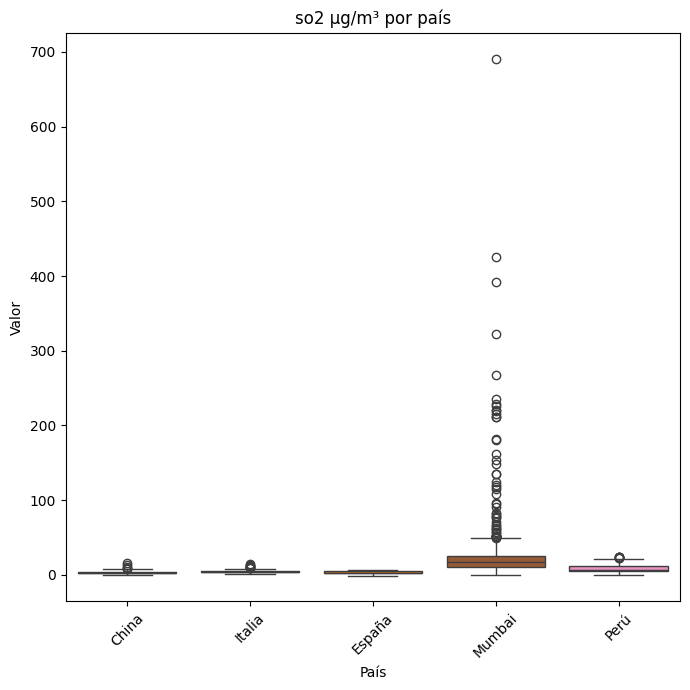

In [319]:
all_dfs = pd.concat(locations_dfs, ignore_index=True)
different_parameters = all_dfs["parameter_name"].unique()

for i, parameter in enumerate(different_parameters):
    plt.figure(figsize=(7, 7))
    plt.title(f"{parameter} por país")
    plt.xlabel("País")
    plt.ylabel("Valor")
    plt.xticks(rotation=45)
    sns.boxplot(
        x="country_name",
        y="value",
        hue="country_name",
        data=all_dfs[all_dfs["parameter_name"] == parameter],
        palette=locations_color_map
    )
    plt.tight_layout()

plt.show()

### Visualización de cada parámetro, en el mapa

In [251]:
def make_heatmap(parameter, lons, lats, values, countries, grid_resolution=500, smoothing_sigma=6):
    """
    Creates a heatmap of a specified parameter using given locations and values.

    Args:
        parameter (str): Name of the parameter (e.g., 'pm25').
        lons (list of float): Longitudes of the locations.
        lats (list of float): Latitudes of the locations.
        values (list of float): Values corresponding to each location.
        countries (list of str): List of country names.
        grid_resolution (int, optional): Resolution of the grid (default is 500).
        smoothing_sigma (float, optional): Sigma for Gaussian smoothing (default is 6).
    """
    grid_lon = np.linspace(-180, 180, grid_resolution)
    grid_lat = np.linspace(-90, 90, grid_resolution)
    grid_lon, grid_lat = np.meshgrid(grid_lon, grid_lat)

    grid_values = np.zeros_like(grid_lon)

    for lon, lat, value in zip(lons, lats, values):
        distance = np.sqrt((grid_lon - lon)**2 + (grid_lat - lat)**2)
        grid_values += value * np.exp(-distance**2 / (2 * 3**2))

    grid_values = gaussian_filter(grid_values, sigma=smoothing_sigma)

    fig = plt.figure(figsize=(12, 8), dpi=100)
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(color='white', linewidth=0.5)

    c = ax.pcolormesh(
        grid_lon, grid_lat, grid_values, cmap='inferno', shading='auto',
        transform=ccrs.PlateCarree()
    )

    cb = plt.colorbar(
        c, ax=ax, orientation='vertical', fraction=0.025, pad=0.035
    )
    cb.set_label(f'Nivel de {parameter}', color='black')
    cb.ax.yaxis.set_tick_params(color='black')
    plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color='black')

    cb.locator = ticker.MaxNLocator(nbins=5)
    cb.update_ticks()

    plt.title(
        f'Mediana de {parameter} en las localizaciones', fontsize=14, color='black'
    )

    sorted_countries_values = sorted(
        zip(countries, values), key=lambda x: x[1], reverse=True
    )
    sorted_legend_labels = [
        f'{country}: {value:.2f}' for country, value in sorted_countries_values
    ]

    bullet_marker = mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor='w',
                                  markersize=7, label='')

    ax.legend(
        [bullet_marker] * len(sorted_countries_values), sorted_legend_labels,
        loc='center', fontsize=10, bbox_to_anchor=(0.5, -0.1), ncol=7,
        title=f'Países y sus medianas de {parameter}'
    )

    plt.tight_layout()
    plt.show()

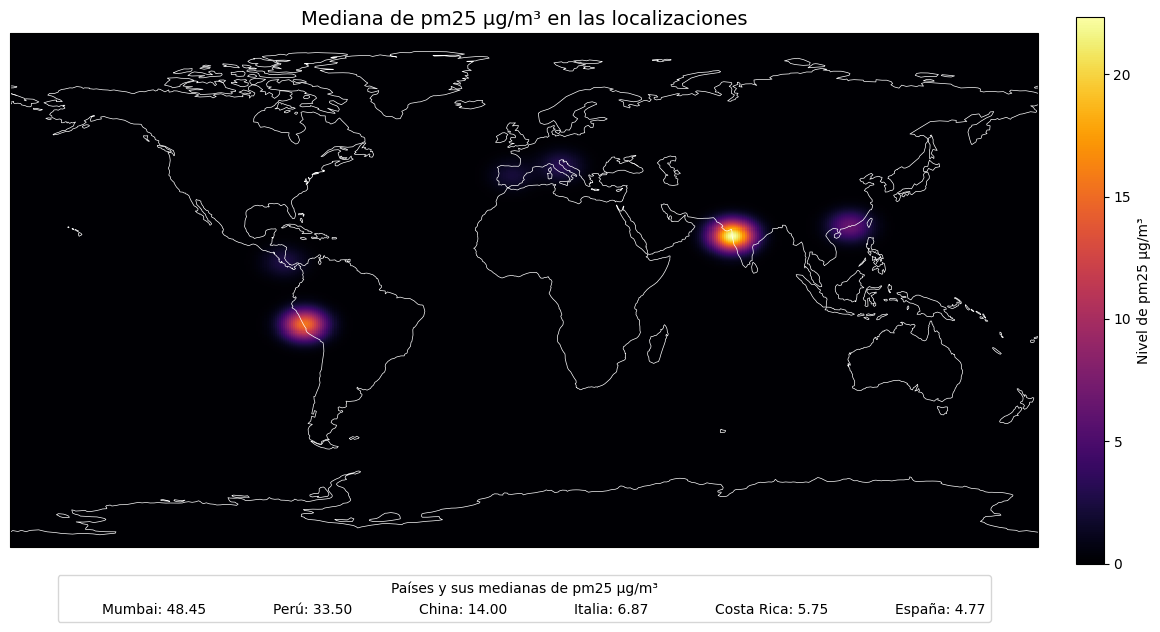

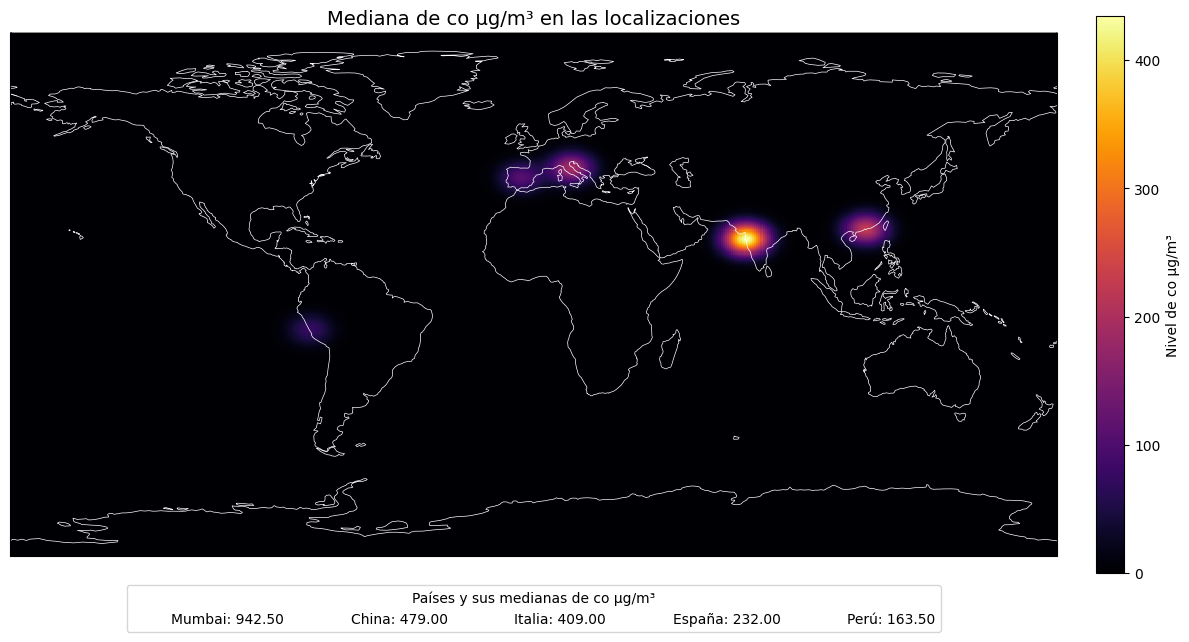

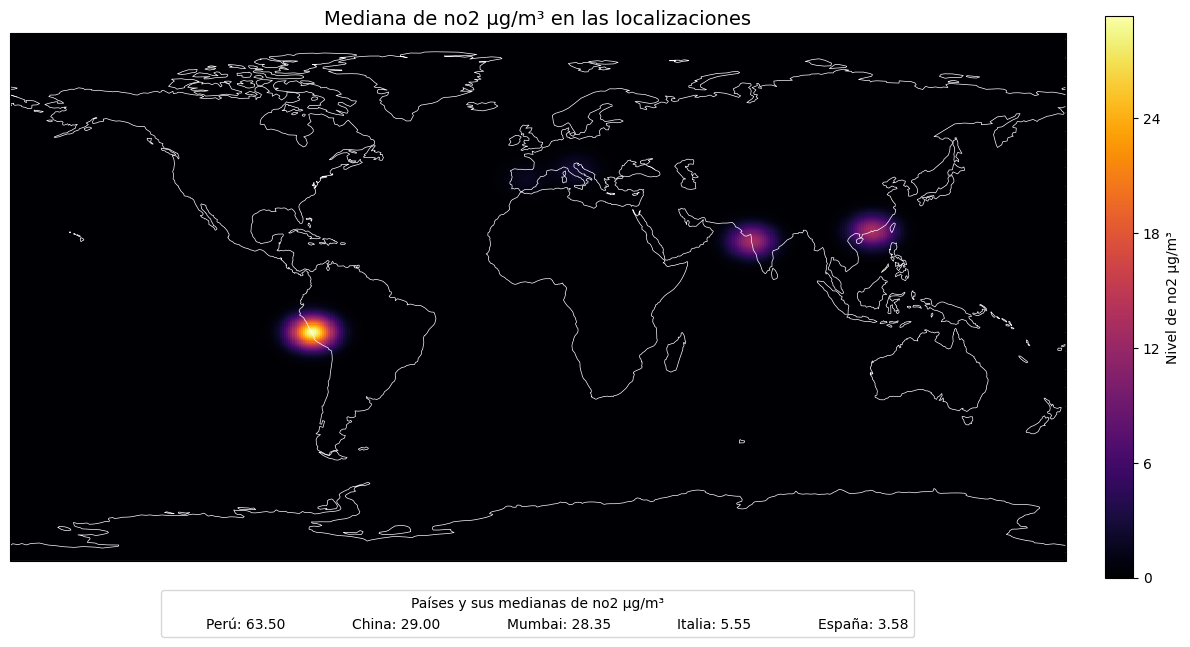

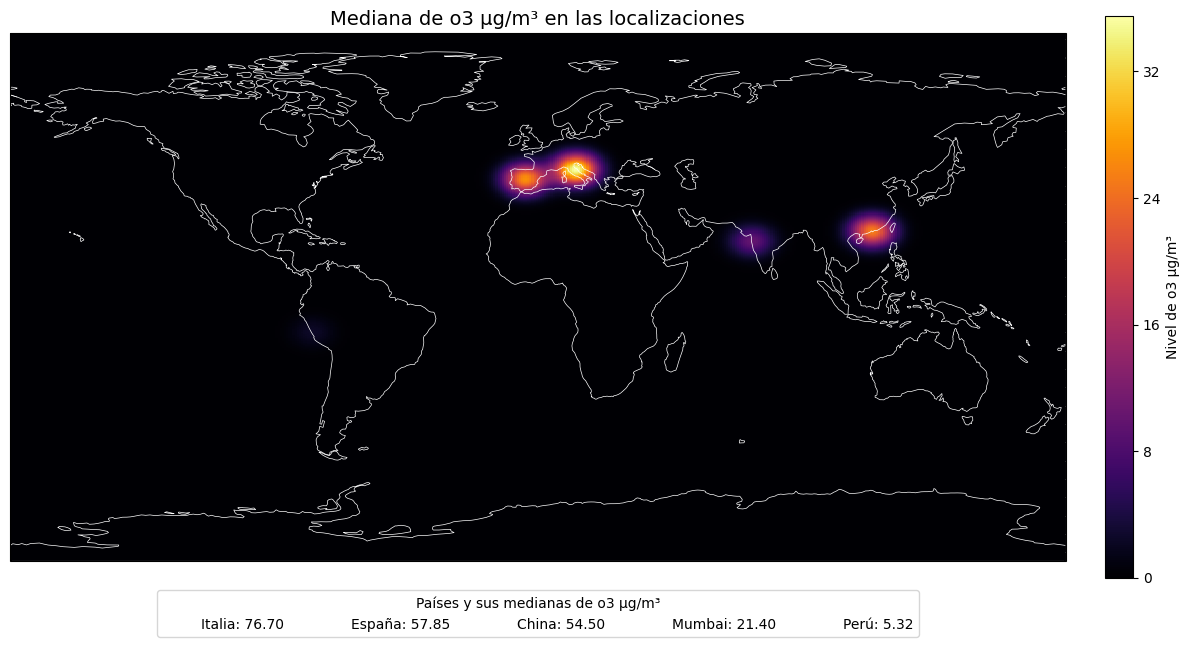

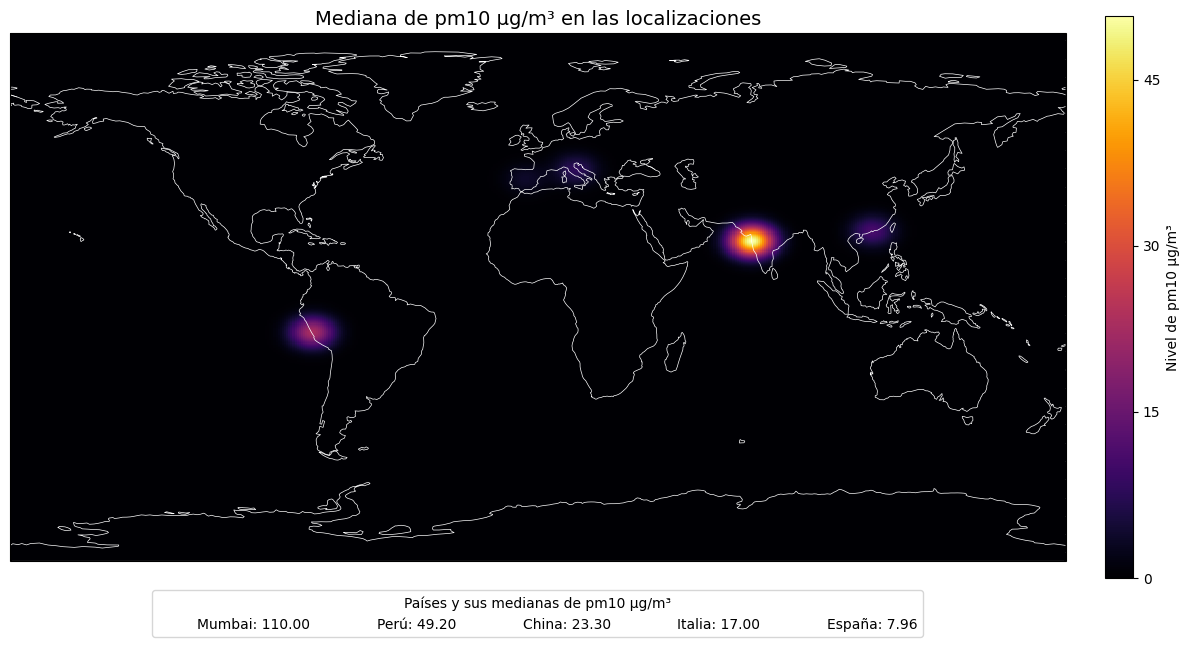

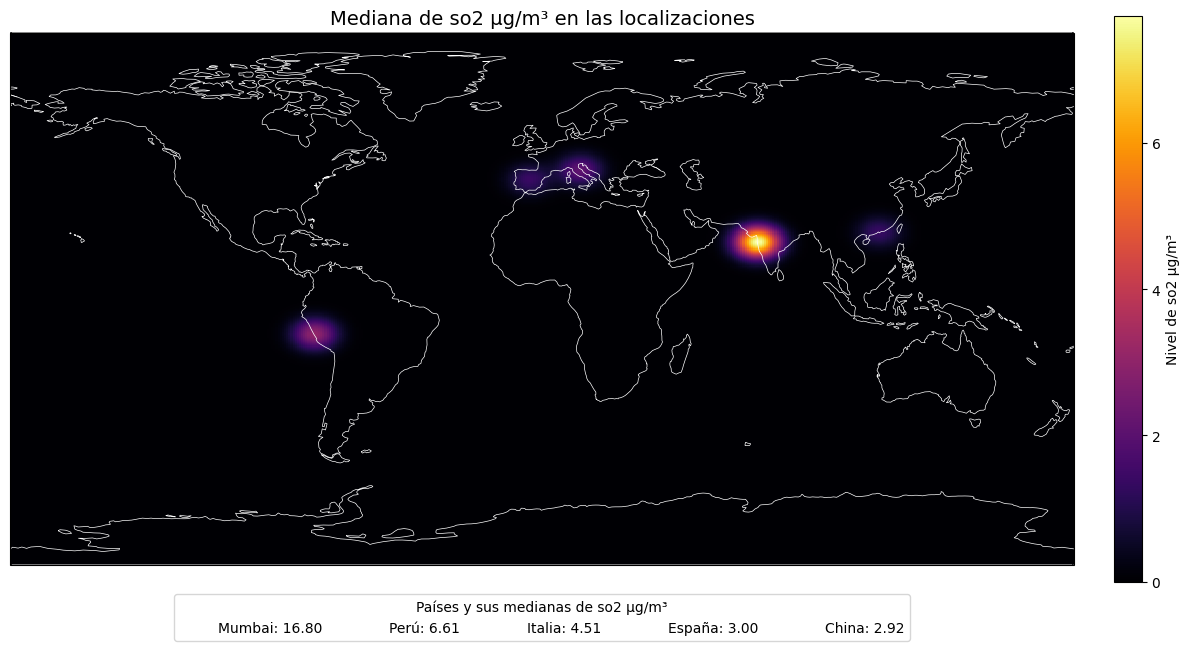

In [252]:
for parameter in different_parameters:
    grouped = all_dfs[all_dfs["parameter_name"] == parameter].groupby('country_name')['value'].median()

    sorted_locations = sorted(locations, key=lambda x: x.country)
    lons, lats, values, countries = [], [], [], []
    for loc in sorted_locations:
        if loc.country in grouped.index:
            lons.append(loc.coordinates['longitude'])
            lats.append(loc.coordinates['latitude'])
            values.append(grouped[loc.country])
            countries.append(loc.country)

    make_heatmap(parameter, lons, lats, values, countries)


## 4.d Análisis multivariable:


### Progresion de tiempo

Podemos analizar los datos inicialmente con las funciones que ofrecen los pandas DF.

In [265]:
locations_dfs = [pd.read_csv(f"{location.file_path}_cleaned.csv") for location in locations]

In [266]:
locations_dfs[0].head()

location_id country_name                 location_name  sensor_id  \
0      3070644   Costa Rica  NASA GSFC Rutgers Calib. N13   10669679   
1      3070644   Costa Rica  NASA GSFC Rutgers Calib. N13   10669679   
2      3070644   Costa Rica  NASA GSFC Rutgers Calib. N13   10669679   
3      3070644   Costa Rica  NASA GSFC Rutgers Calib. N13   10669679   
4      3070644   Costa Rica  NASA GSFC Rutgers Calib. N13   10669679   

              from_date               to_date parameter_name parameter_units  \
0  2024-09-19T06:00:00Z  2024-09-20T06:00:00Z     pm25 µg/m³           µg/m³   
1  2024-09-20T06:00:00Z  2024-09-21T06:00:00Z     pm25 µg/m³           µg/m³   
2  2024-10-08T06:00:00Z  2024-10-09T06:00:00Z     pm25 µg/m³           µg/m³   
3  2024-10-09T06:00:00Z  2024-10-10T06:00:00Z     pm25 µg/m³           µg/m³   
4  2024-10-10T06:00:00Z  2024-10-11T06:00:00Z     pm25 µg/m³           µg/m³   

   value  aggregated_count  summary_avg  summary_max  summary_median  \
0   6.78                22     6.778636         7.59            6.67   
1   6.94                31     6.943226         8.25            6.90   
2   5.89                30     5.889333         6.32            5.84   
3   5.74                78     5.736795         7.80            5.53   
4   7.50                75     7.501467        12.83            7.65   

   summary_min  summary_q02  summary_q25  summary_q75  summary_q98  summary_sd  
0         6.32       6.3368       6.5925       6.9600       7.4304    0.318094  
1         5.91       5.9760       6.5000       7.3150       8.2380    0.631593  
2         5.37       5.4860       5.7025       6.0825       6.3026    0.243607  
3         4.57       4.7640       5.2725       6.0325       7.3452    0.704368  
4         4.06       4.1136       5.6000       9.4250      12.1064    2.345845

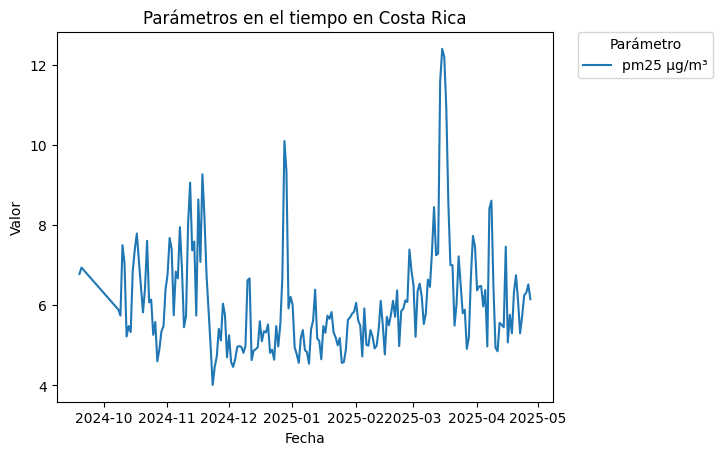

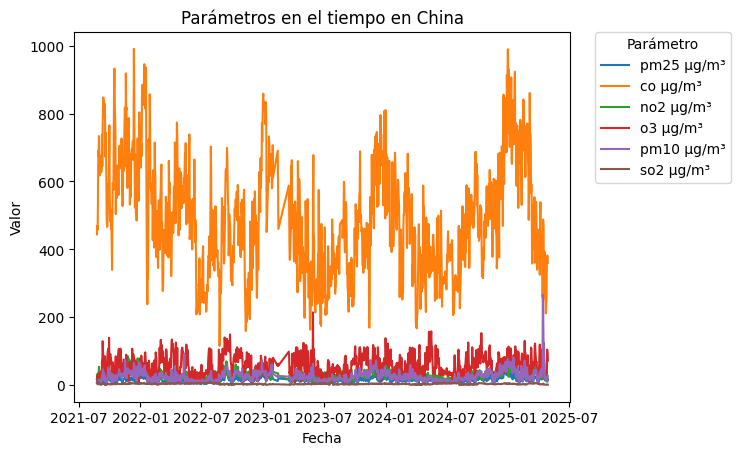

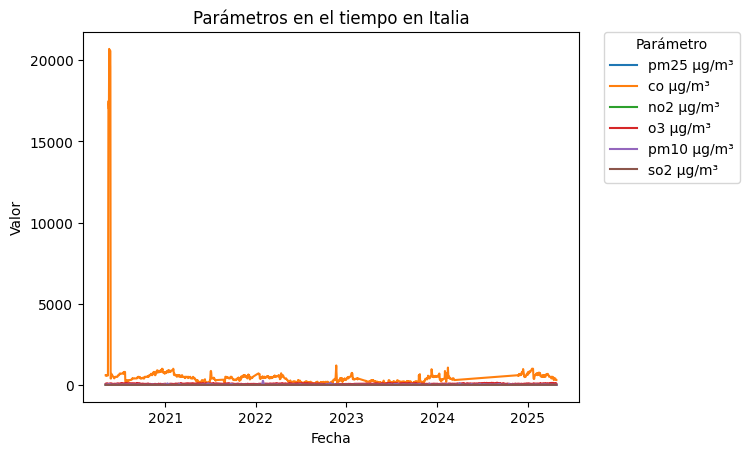

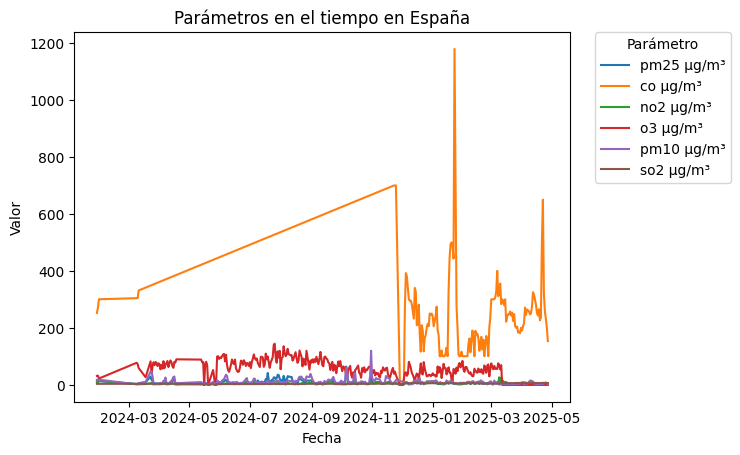

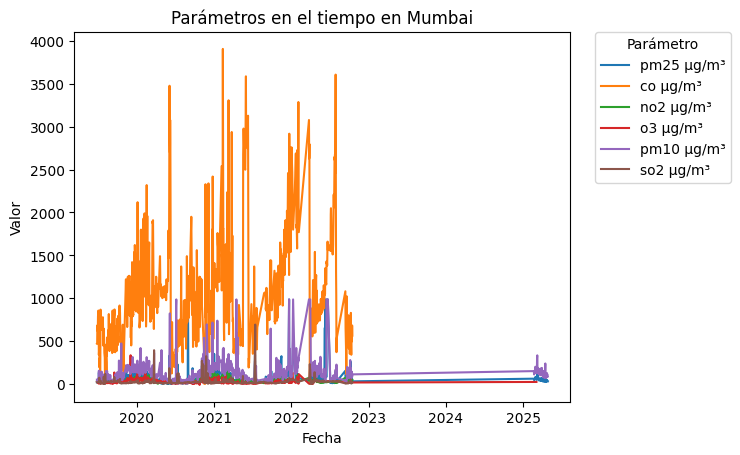

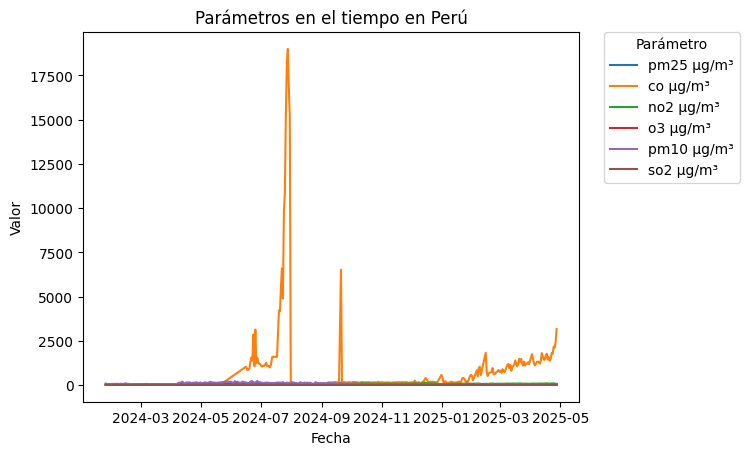

In [272]:
df_countries = []
for country in locations_dfs:
    df_countries.append(country[['country_name', 'from_date', 'parameter_name', 'value']].copy())

for i, df in enumerate(df_countries):
    df_countries[i]['from_date'] = pd.to_datetime(df['from_date'])
    df_countries[i] = df_countries[i].sort_values(by='from_date')

    for j in range(len(df_countries[i]['parameter_name'].unique())):
        x = df_countries[i][df_countries[i]['parameter_name'] == different_parameters[j]]['from_date']
        y = df_countries[i][df_countries[i]['parameter_name'] == different_parameters[j]]['value']
        plt.plot(x, y, label=different_parameters[j])

    plt.title(f"Parámetros en el tiempo en {df_countries[i]['country_name'].iloc[0]}")
    # Move legend outside the plot
    plt.legend(title="Parámetro", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.xlabel("Fecha")
    plt.ylabel("Valor")
    plt.show()

Estos gráficos dan información valiosa, pero tal vez interesa más ver tendencias en los parámetros de cada país que comparar los parámetros entre sí, ya que los parámetros se miden en distintas escalas, y hacer análisis de tendencias con estos gráficos puede ser engañoso. Por ello, decidimos hacer una normalización de los datos para ver patrones.

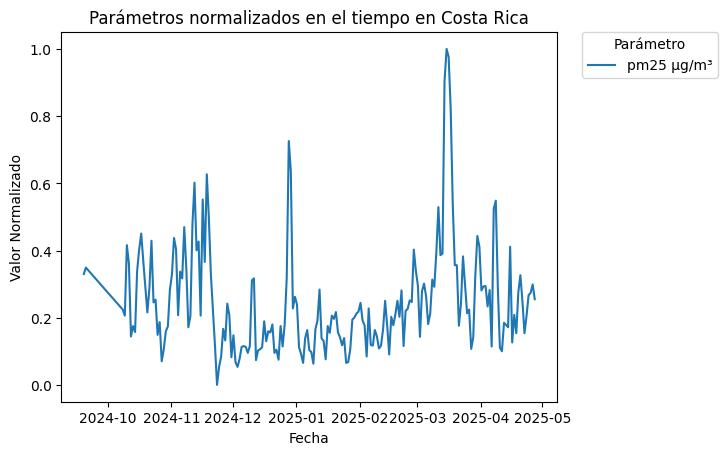

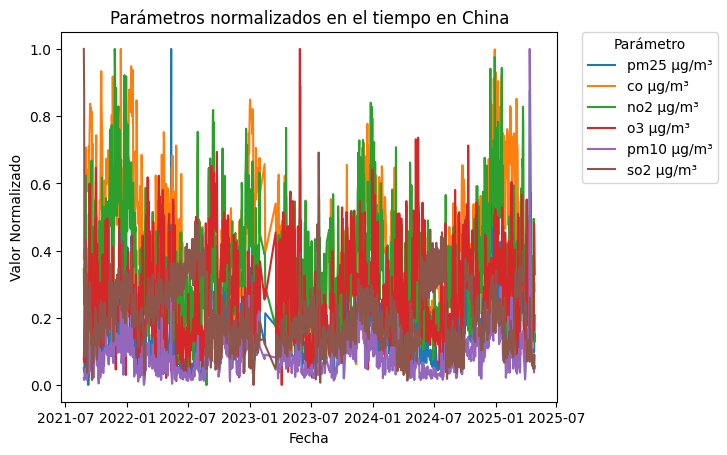

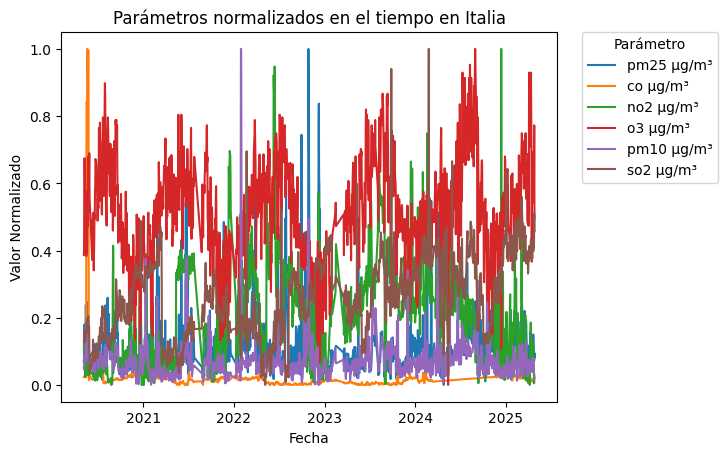

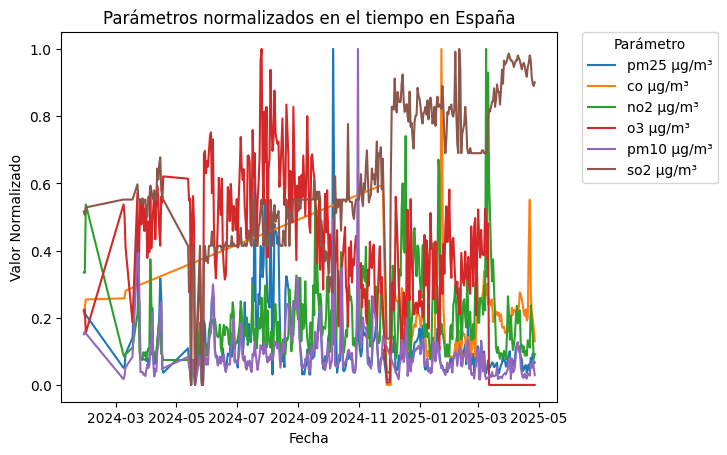

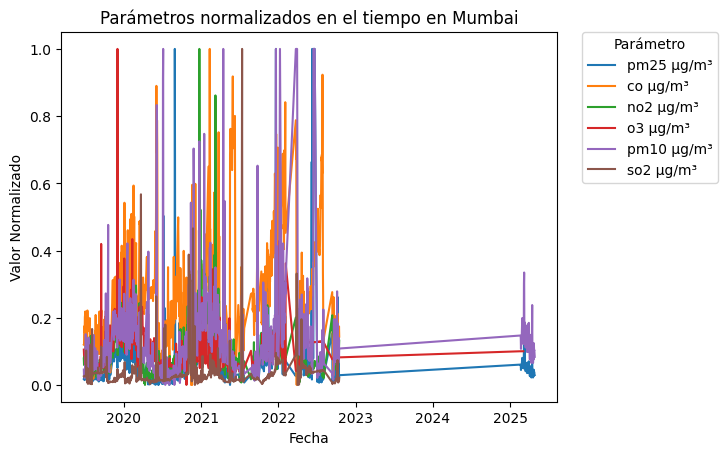

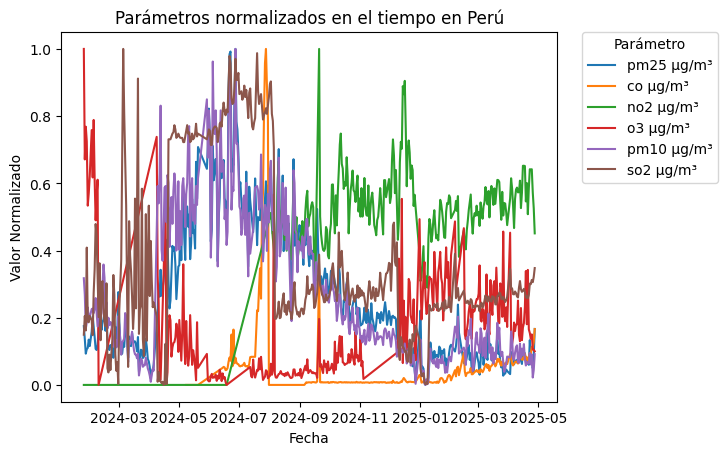

In [367]:
df_countries = []
for country in locations_dfs:
    df_countries.append(country[['country_name', 'from_date', 'parameter_name', 'value']].copy())

scaler = MinMaxScaler()

for i, df in enumerate(df_countries):
    df_countries[i]['from_date'] = pd.to_datetime(df['from_date'])
    df_countries[i] = df_countries[i].sort_values(by='from_date')

    # Normalize y values for each country
    for j in range(len(df_countries[i]['parameter_name'].unique())):
        x = df_countries[i][df_countries[i]['parameter_name'] == different_parameters[j]]['from_date']
        y = df_countries[i][df_countries[i]['parameter_name'] == different_parameters[j]]['value']

        # Normalizing the y values
        y_normalized = scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

        # Plot the normalized data
        plt.plot(x, y_normalized, label=different_parameters[j])

    plt.title(f"Parámetros normalizados en el tiempo en {df_countries[i]['country_name'].iloc[0]}")
    # Move legend outside the plot
    plt.legend(title="Parámetro", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.xlabel("Fecha")
    plt.ylabel("Valor Normalizado")
    plt.show()

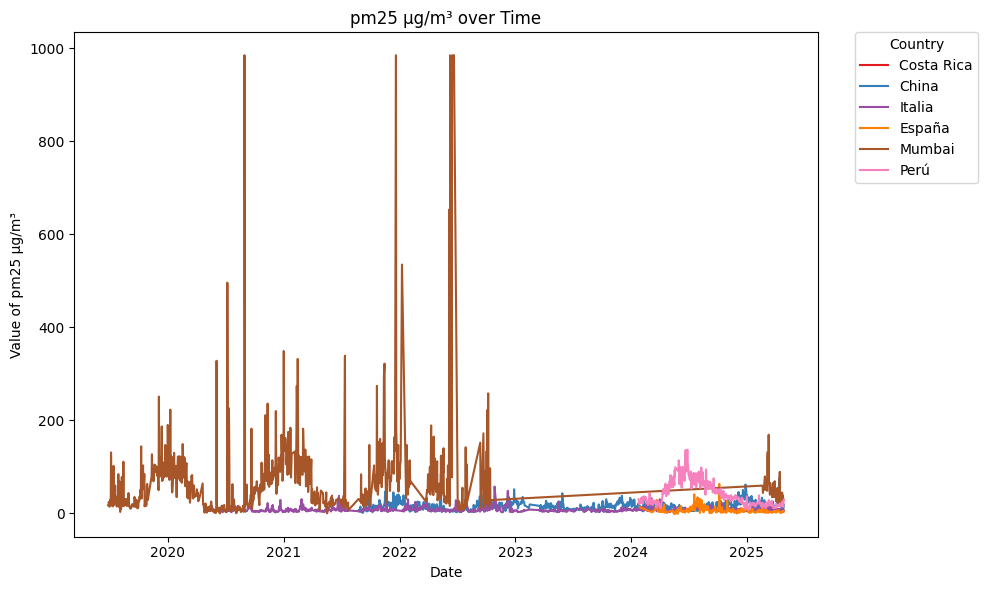

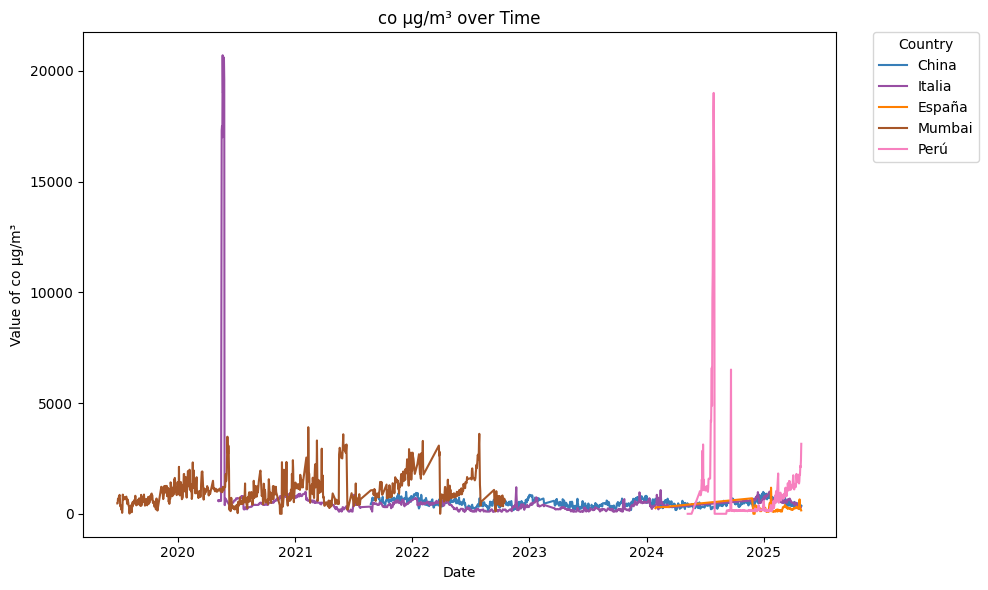

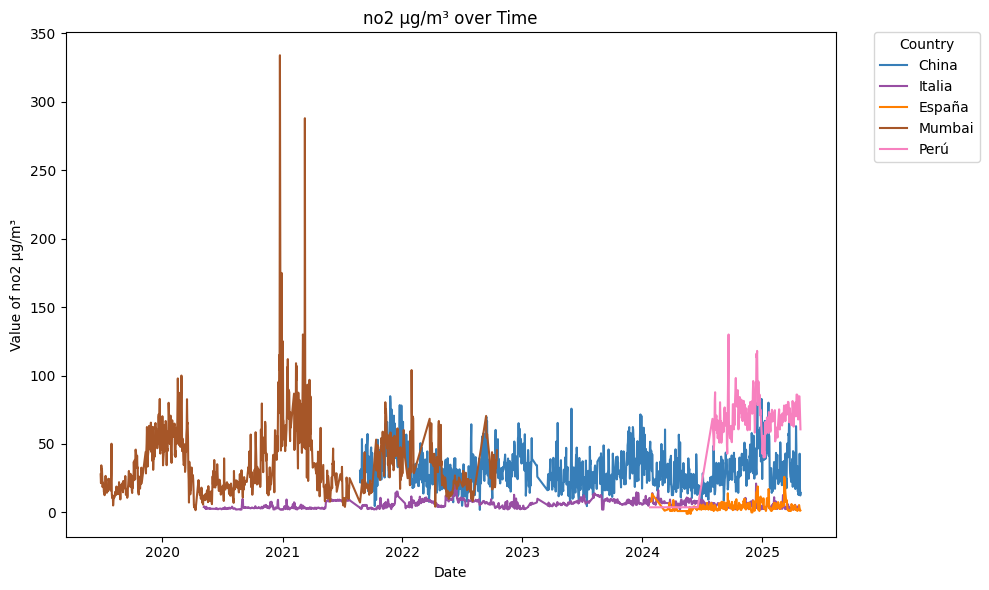

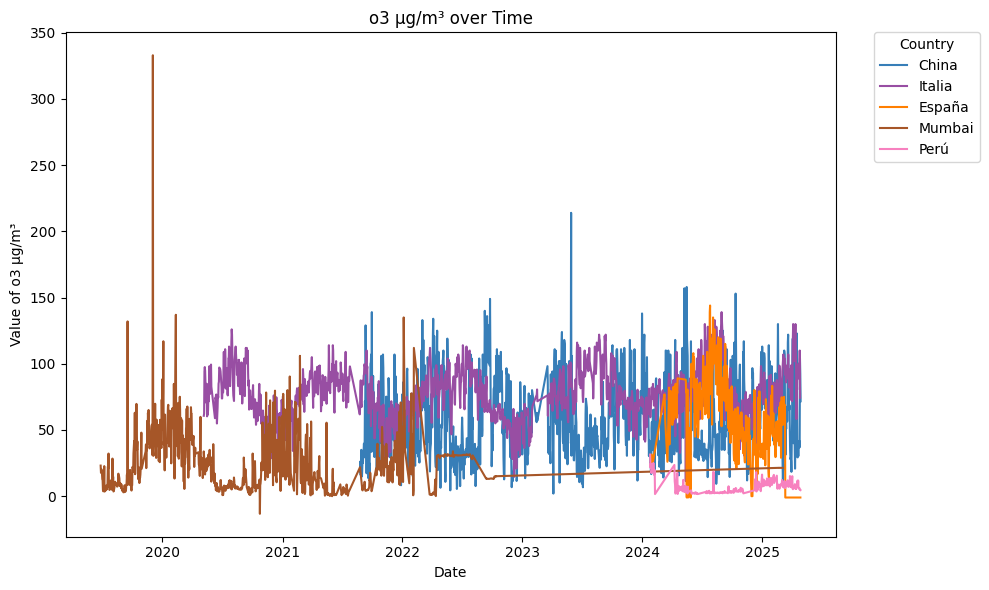

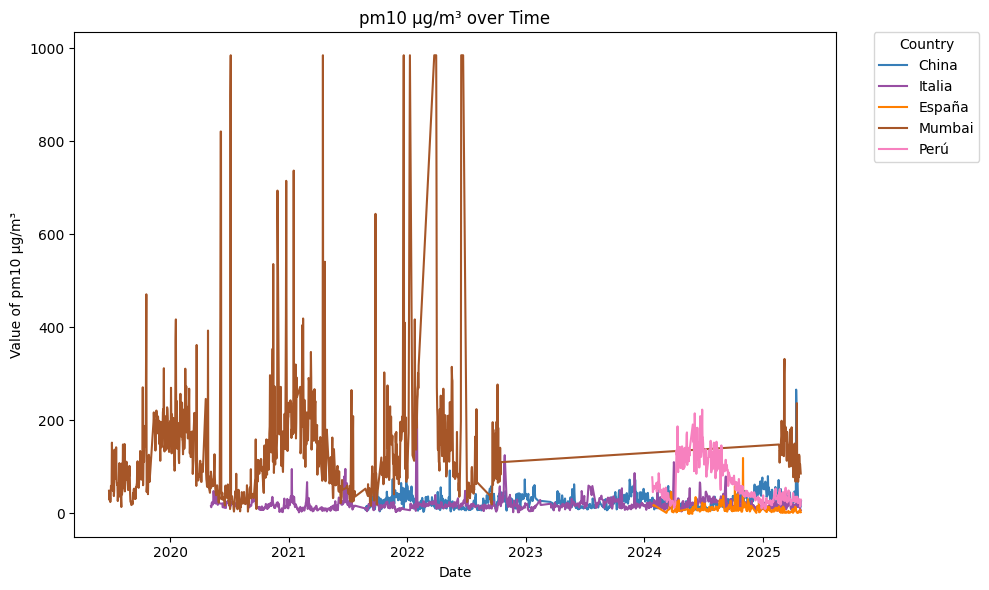

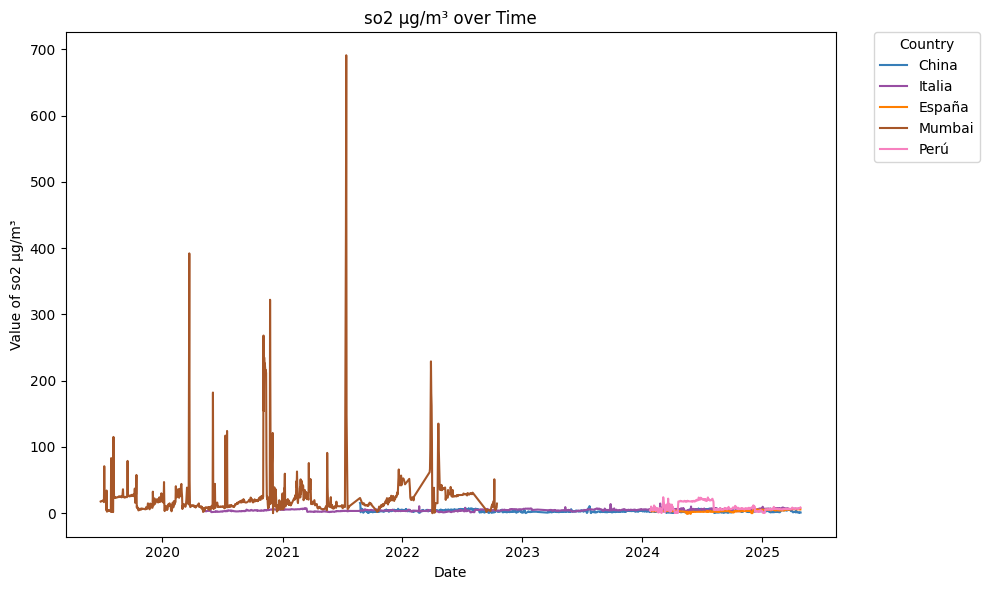

In [281]:
df_countries = []

for country in locations_dfs:
    df_countries.append(country[['country_name', 'from_date', 'parameter_name', 'value']].copy())

parameters = different_parameters

for parameter in parameters:
    plt.figure(figsize=(10, 6))

    for i, df in enumerate(df_countries):
        df_param = df[df['parameter_name'] == parameter]

        if not df_param.empty:
            df_param.loc[:, 'from_date'] = pd.to_datetime(df_param['from_date'])
            df_param = df_param.sort_values(by='from_date')

            color = locations_color_map[df_param['country_name'].unique()[0]]

            plt.plot(df_param['from_date'], df_param['value'], label=df_param['country_name'].iloc[0], color=color)

    plt.title(f"{parameter} over Time")
    plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.xlabel("Date")
    plt.ylabel(f"Value of {parameter}")
    plt.tight_layout()
    plt.show()

### Covarianzas

In [320]:
all_dfs.head()

location_id country_name                 location_name  sensor_id  \
0      3070644   Costa Rica  NASA GSFC Rutgers Calib. N13   10669679   
1      3070644   Costa Rica  NASA GSFC Rutgers Calib. N13   10669679   
2      3070644   Costa Rica  NASA GSFC Rutgers Calib. N13   10669679   
3      3070644   Costa Rica  NASA GSFC Rutgers Calib. N13   10669679   
4      3070644   Costa Rica  NASA GSFC Rutgers Calib. N13   10669679   

              from_date               to_date parameter_name parameter_units  \
0  2024-09-19T06:00:00Z  2024-09-20T06:00:00Z     pm25 µg/m³           µg/m³   
1  2024-09-20T06:00:00Z  2024-09-21T06:00:00Z     pm25 µg/m³           µg/m³   
2  2024-10-08T06:00:00Z  2024-10-09T06:00:00Z     pm25 µg/m³           µg/m³   
3  2024-10-09T06:00:00Z  2024-10-10T06:00:00Z     pm25 µg/m³           µg/m³   
4  2024-10-10T06:00:00Z  2024-10-11T06:00:00Z     pm25 µg/m³           µg/m³   

   value  aggregated_count  summary_avg  summary_max  summary_median  \
0   6.78                22     6.778636         7.59            6.67   
1   6.94                31     6.943226         8.25            6.90   
2   5.89                30     5.889333         6.32            5.84   
3   5.74                78     5.736795         7.80            5.53   
4   7.50                75     7.501467        12.83            7.65   

   summary_min  summary_q02  summary_q25  summary_q75  summary_q98  summary_sd  
0         6.32       6.3368       6.5925       6.9600       7.4304    0.318094  
1         5.91       5.9760       6.5000       7.3150       8.2380    0.631593  
2         5.37       5.4860       5.7025       6.0825       6.3026    0.243607  
3         4.57       4.7640       5.2725       6.0325       7.3452    0.704368  
4         4.06       4.1136       5.6000       9.4250      12.1064    2.345845

In [327]:
merged_df = all_dfs.copy()
merged_df['from_date'] = pd.to_datetime(merged_df['from_date'])

# Pivot the table to place every parameter as a column and each row as a date
df_pivot = merged_df.pivot_table(
    index=['country_name', 'from_date'],
    columns='parameter_name',
    values='value'
).reset_index()

# Remove the index name
df_pivot.columns.name = None
df_pivot.head()

country_name                 from_date  co µg/m³  no2 µg/m³  o3 µg/m³  \
0        China 2021-08-24 16:00:00+00:00     444.0       30.4      18.4   
1        China 2021-08-25 16:00:00+00:00     470.0       21.8      26.2   
2        China 2021-08-26 16:00:00+00:00     457.0       30.1      16.0   
3        China 2021-08-27 16:00:00+00:00     539.0       31.5      20.2   
4        China 2021-08-28 16:00:00+00:00     691.0       25.8      35.0   

   pm10 µg/m³  pm25 µg/m³  so2 µg/m³  
0        8.54        5.32      15.30  
1        6.89        4.32      13.50  
2       10.50        6.55       1.33  
3       15.10        7.83       2.95  
4       12.60        7.21       4.86

#### Análisis de correlación

Vamos a analizar si es que existe alguna correlación entre los parámetros existentes.

In [347]:
correlation_df = df_pivot[list(set(list(df_pivot.columns)) - {"country_name", "from_date"})].corr()
correlation_df

so2 µg/m³  o3 µg/m³  pm10 µg/m³  co µg/m³  no2 µg/m³  pm25 µg/m³
so2 µg/m³    1.000000 -0.197008    0.366076  0.113376   0.136225    0.250923
o3 µg/m³    -0.197008  1.000000   -0.256398 -0.117754  -0.356578   -0.203597
pm10 µg/m³   0.366076 -0.256398    1.000000  0.198450   0.358364    0.622072
co µg/m³     0.113376 -0.117754    0.198450  1.000000   0.130395    0.144424
no2 µg/m³    0.136225 -0.356578    0.358364  0.130395   1.000000    0.277198
pm25 µg/m³   0.250923 -0.203597    0.622072  0.144424   0.277198    1.000000

A partir de la tabla, es notable que las correlaciones son bajas en general, y no parece haber ninguna notable. Sin embargo, la que tiene un valor más alto es pm10 con pm25, lo cual tiene sentido, pues son de una misma familia de contaminantes (es esperable que se comporten similar). Ahora, visto en un heatmap, primero pasamos los valores a valor absoluto:

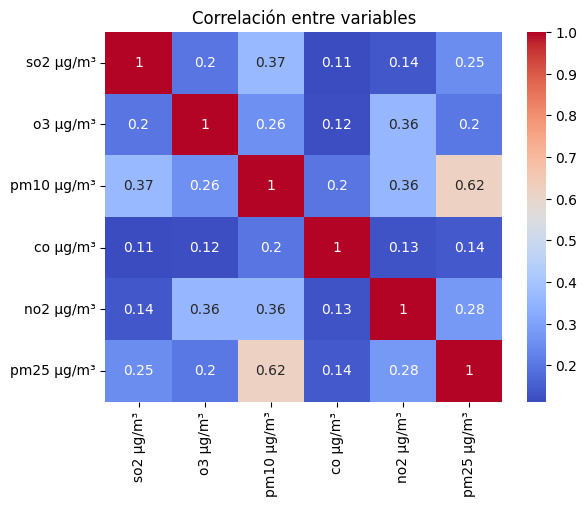

In [362]:
plt.title("Correlación entre variables")
sns.heatmap(
    correlation_df.abs(),
    annot=True,
    cmap='coolwarm',
)
plt.show()

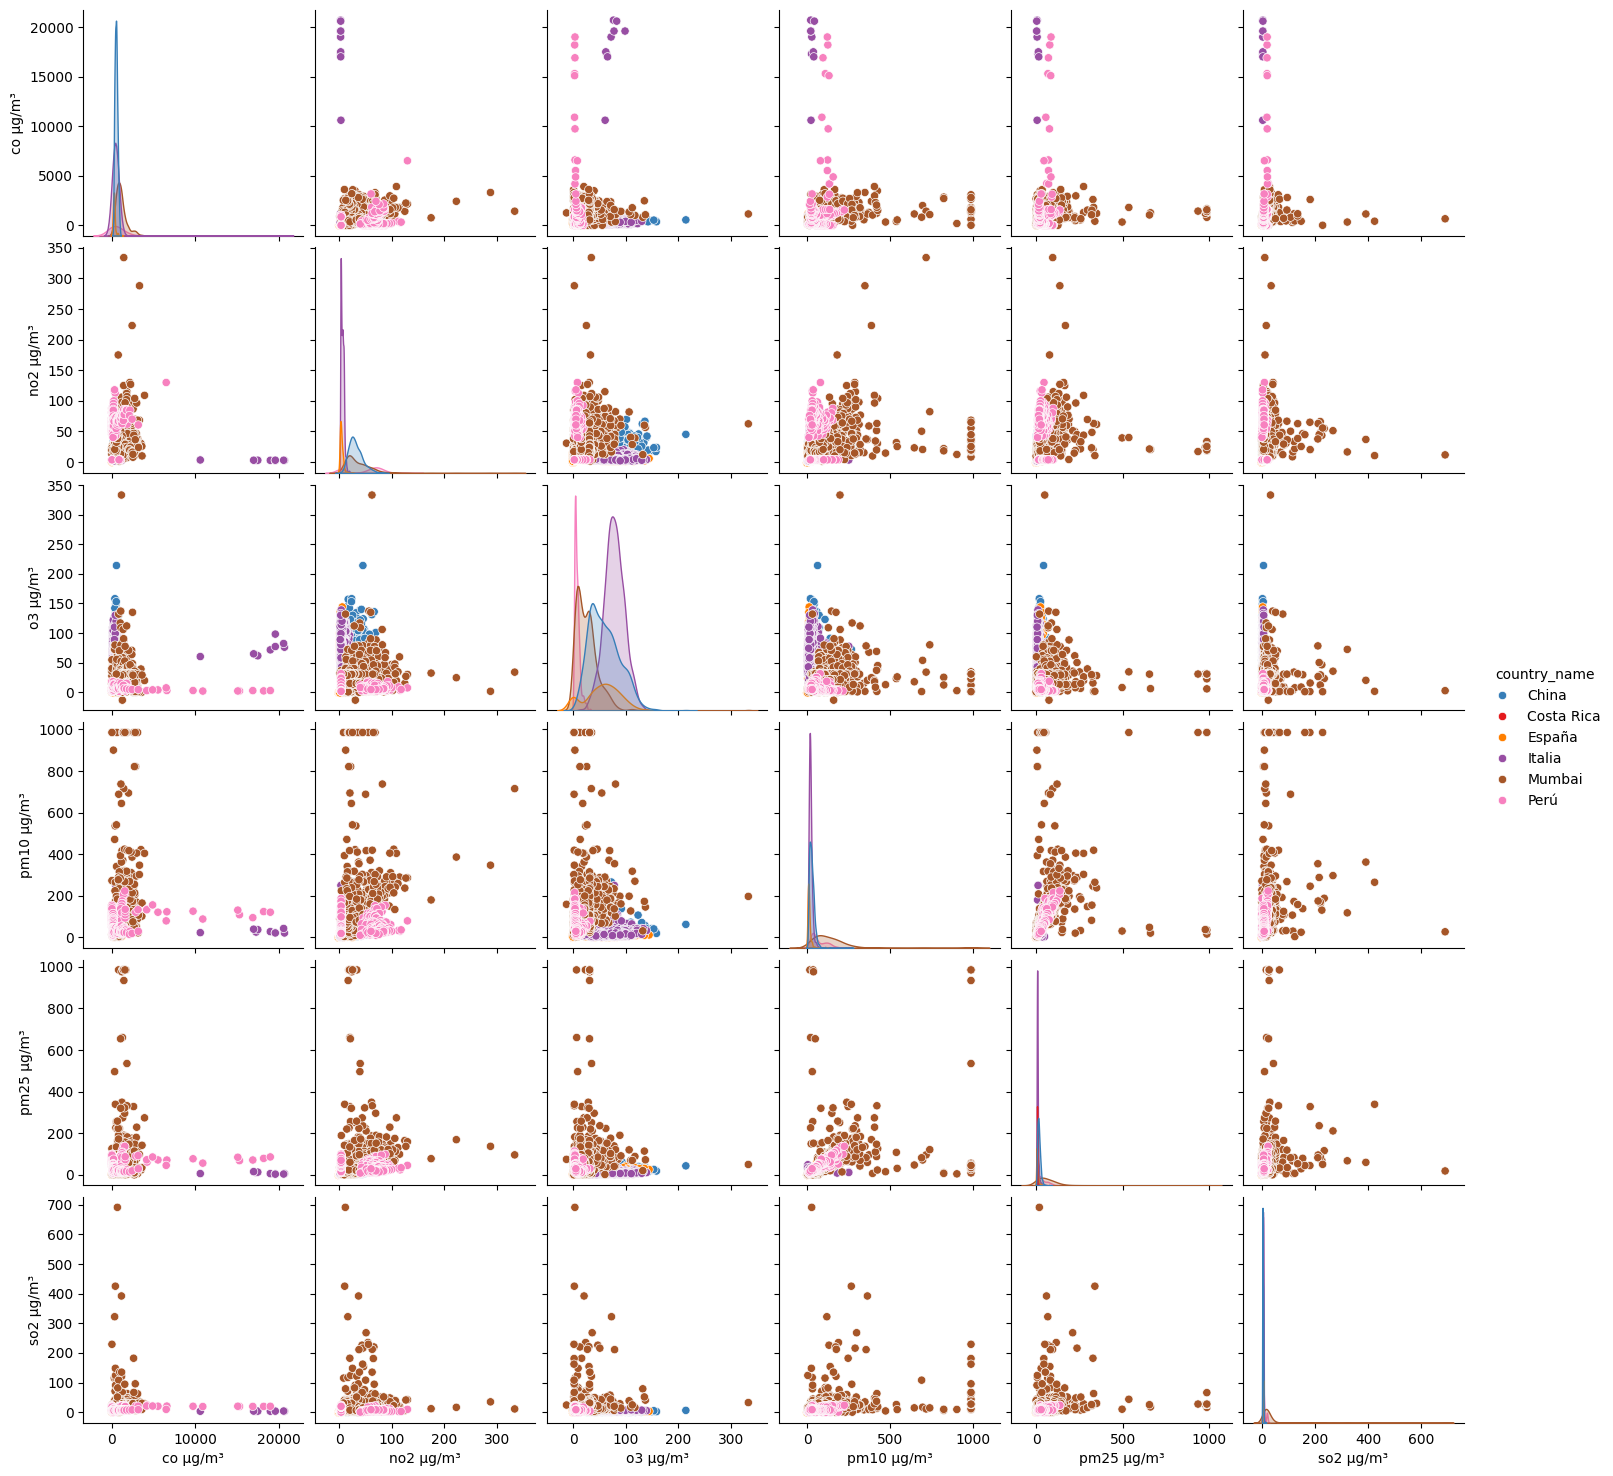

In [330]:
sns.pairplot(df_pivot, hue="country_name", palette=locations_color_map)

#### Análisis de covarianza PM1

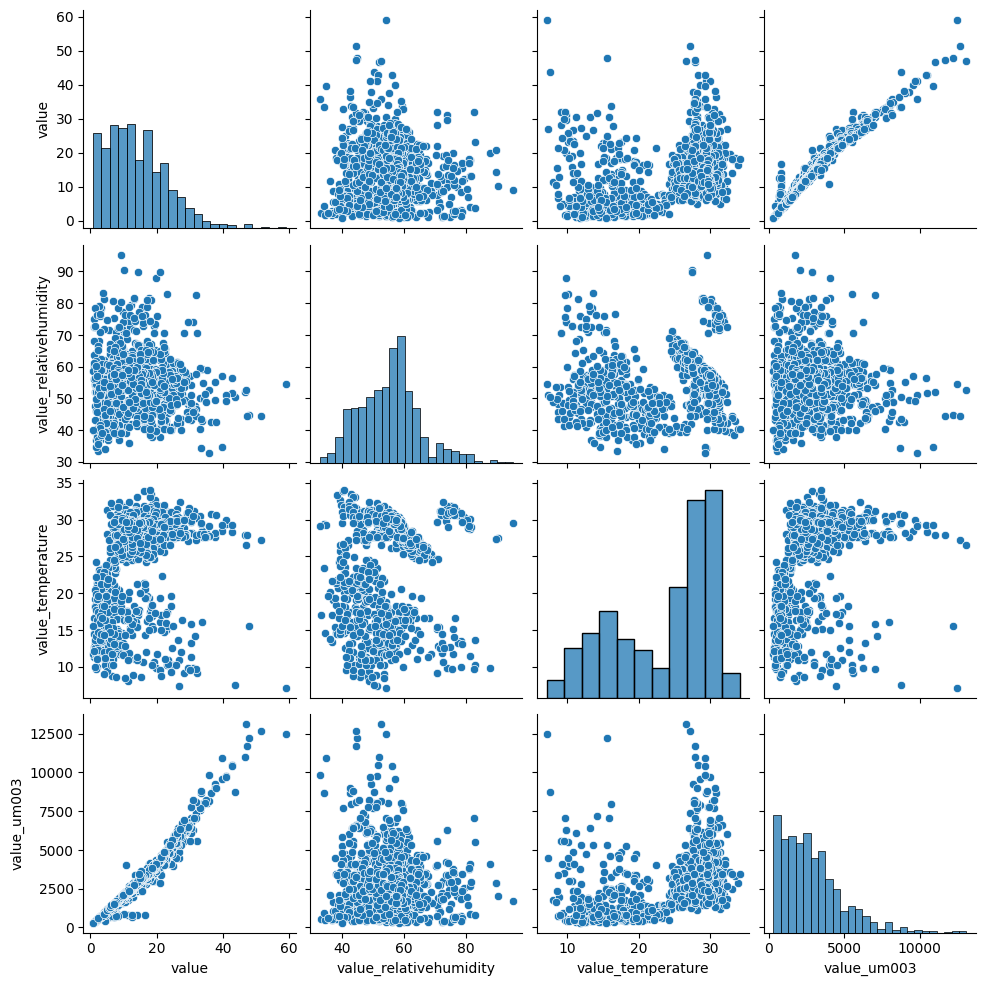

In [ ]:
import re

pattern = re.compile(r'value*')
filtered_df_pm1 = dfs_particles[1].filter(regex=pattern)

plot_data = filtered_df_pm1[['value', 'value_relativehumidity', 'value_temperature', 'value_um003']]

sns.pairplot(plot_data)


Al analizar los gráficos de las partículas pm1 la única correlación que existe es con um003

In [ ]:
filtered_df_pm1.corr(method='pearson',numeric_only=True)

value  value_relativehumidity  value_temperature  \
value                   1.000000               -0.074242           0.346741   
value_relativehumidity -0.074242                1.000000           0.131949   
value_temperature       0.346741                0.131949           1.000000   
value_um003             0.980629               -0.066250           0.385928   
value_co                     NaN                     NaN                NaN   
value_no                     NaN                     NaN                NaN   
value_no2                    NaN                     NaN                NaN   
value_o3                     NaN                     NaN                NaN   
value_so2                    NaN                     NaN                NaN   

                        value_um003  value_co  value_no  value_no2  value_o3  \
value                      0.980629       NaN       NaN        NaN       NaN   
value_relativehumidity    -0.066250       NaN       NaN        NaN       NaN   
value_temperature          0.385928       NaN       NaN        NaN       NaN   
value_um003                1.000000       NaN       NaN        NaN       NaN   
value_co                        NaN       NaN       NaN        NaN       NaN   
value_no                        NaN       NaN       NaN        NaN       NaN   
value_no2                       NaN       NaN       NaN        NaN       NaN   
value_o3                        NaN       NaN       NaN        NaN       NaN   
value_so2                       NaN       NaN       NaN        NaN       NaN   

                        value_so2  
value                         NaN  
value_relativehumidity        NaN  
value_temperature             NaN  
value_um003                   NaN  
value_co                      NaN  
value_no                      NaN  
value_no2                     NaN  
value_o3                      NaN  
value_so2                     NaN

Revisando la tabla de correlación para pm1 no se puede obtener mucha inforación ya que hay muy pocos registros de estos sensores que hagan match con los otros registros

#### Análisis de covarianza PM10

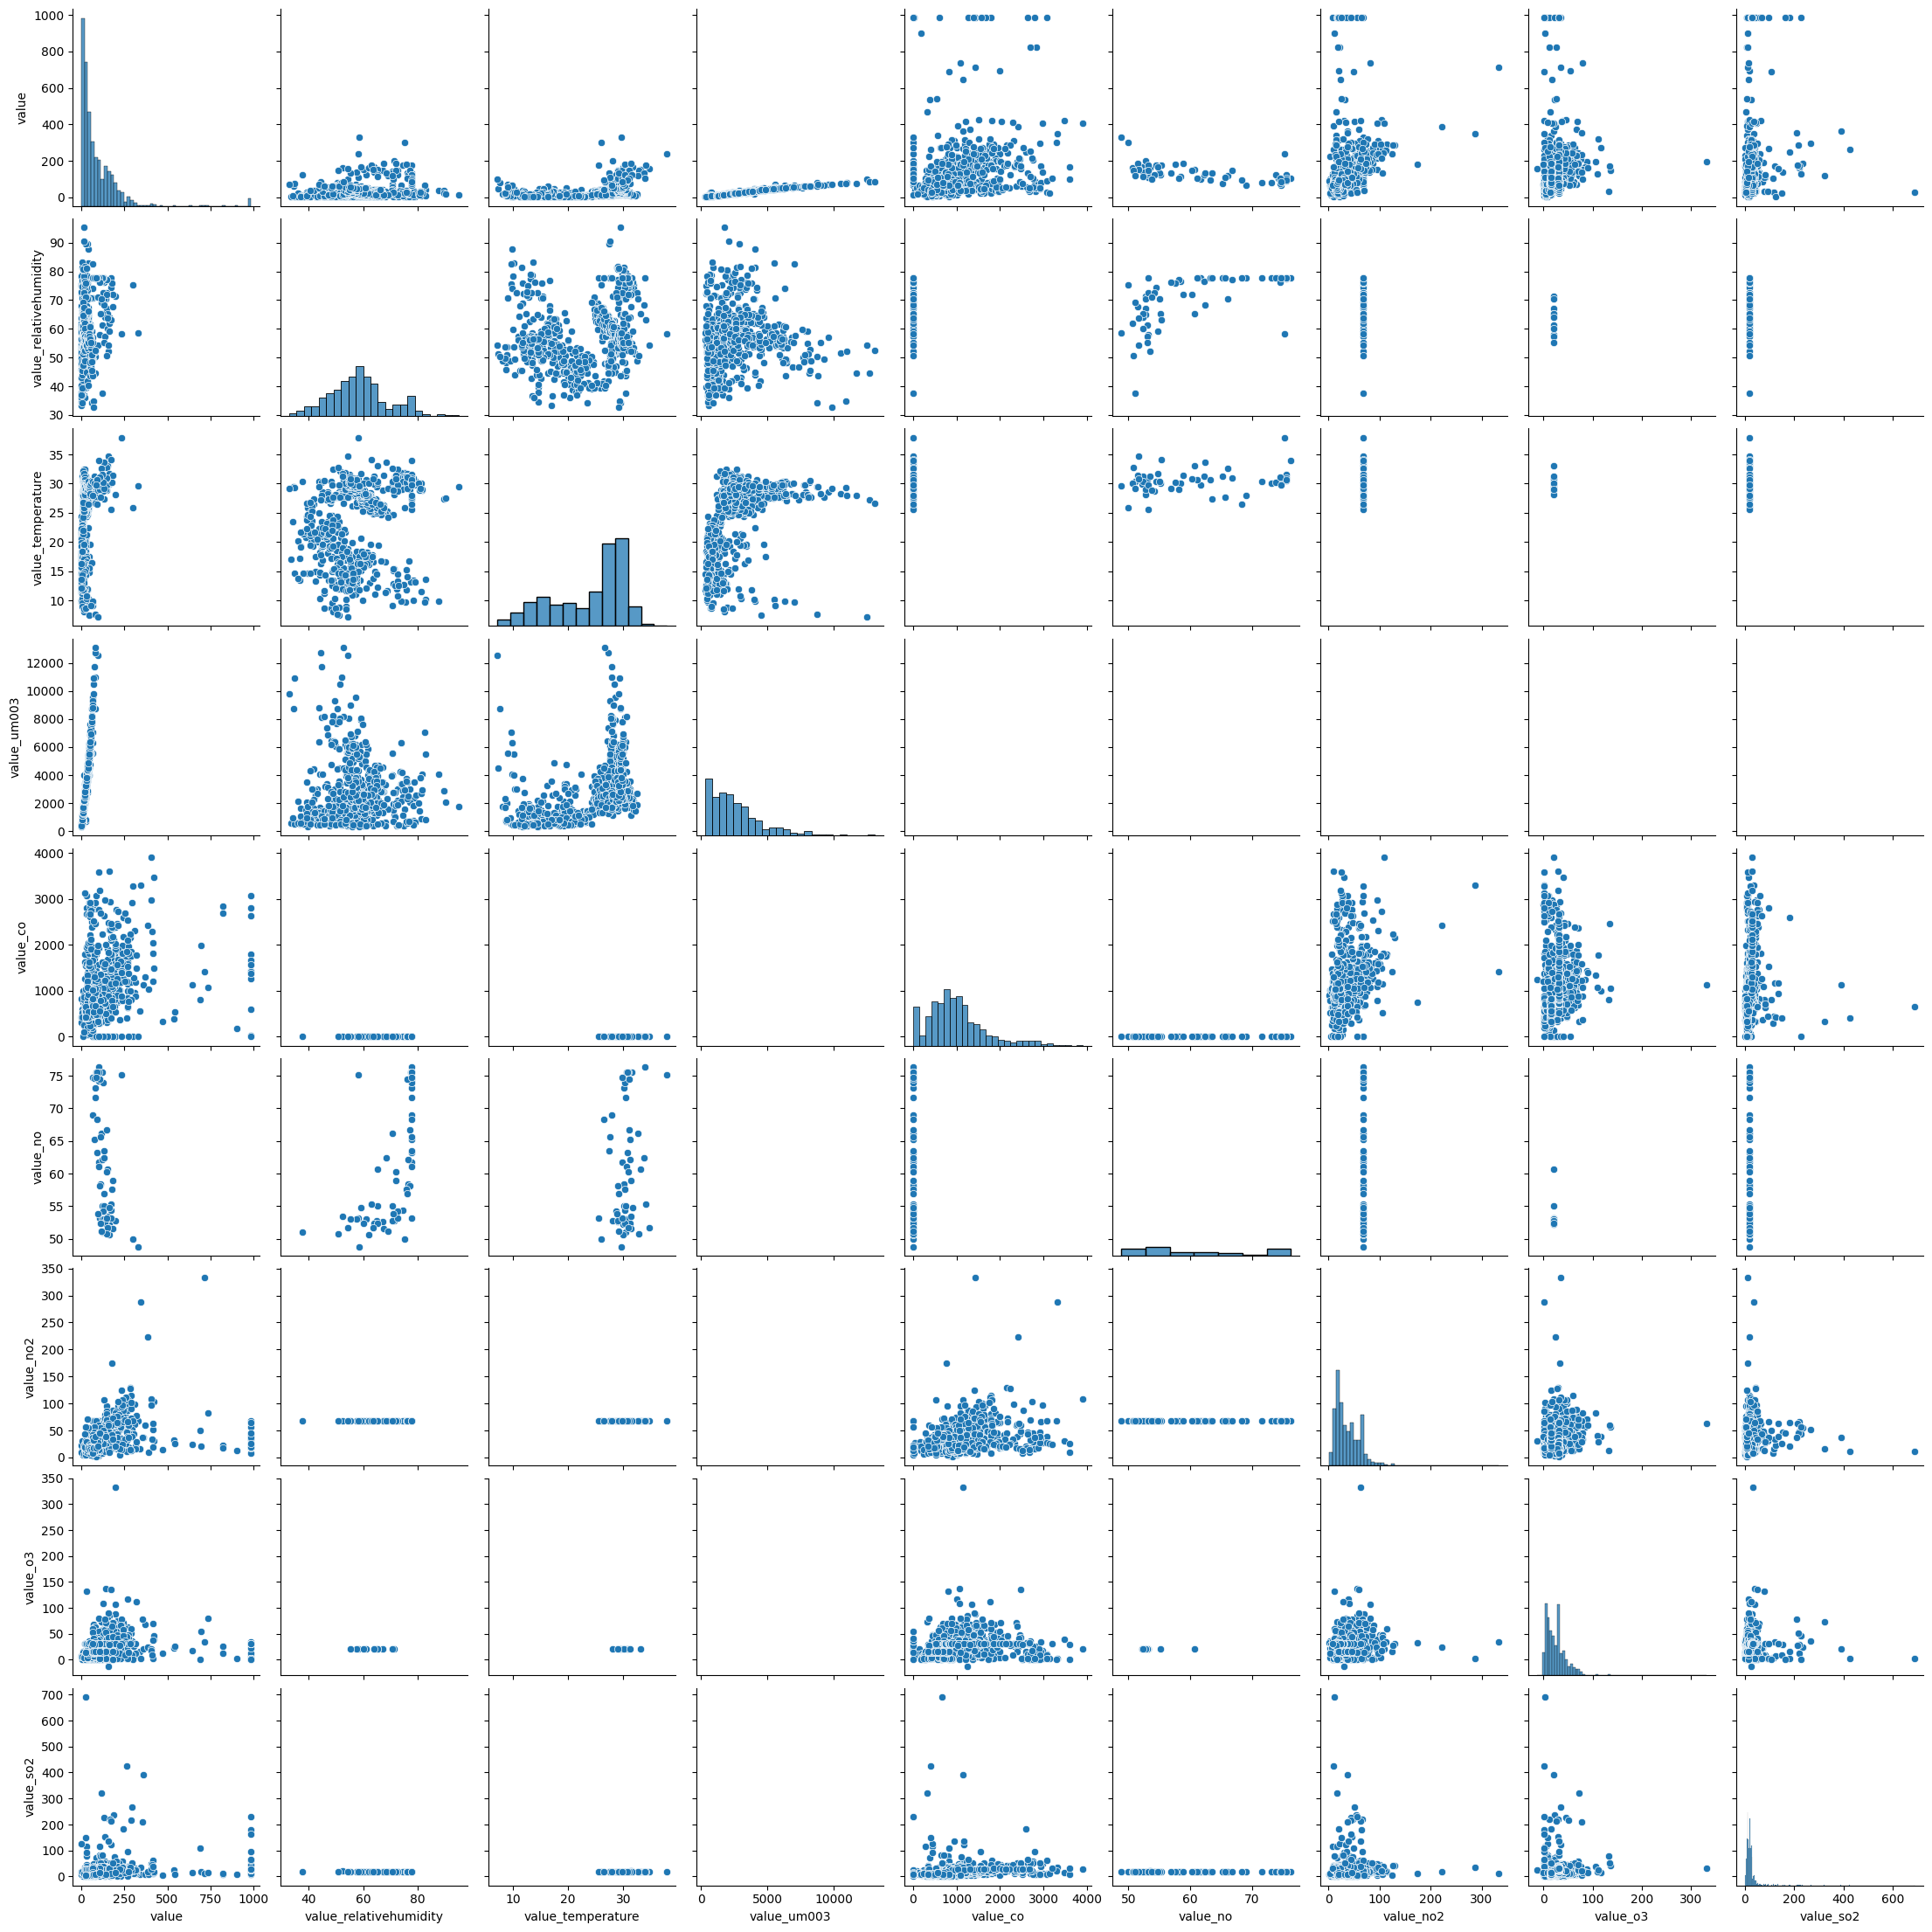

In [ ]:
import re

pattern = re.compile(r'value*')
filtered_df_pm10 = dfs_particles[2].filter(regex=pattern)

plot_data = filtered_df_pm10[['value', 'value_relativehumidity', 'value_temperature', 'value_um003',
       'value_co', 'value_no', 'value_no2', 'value_o3', 'value_so2']]

sns.pairplot(plot_data)

In [ ]:
filtered_df_pm10.corr(method='pearson',numeric_only=True)

value  value_relativehumidity  value_temperature  \
value                   1.000000                0.266955           0.409374   
value_relativehumidity  0.266955                1.000000           0.218579   
value_temperature       0.409374                0.218579           1.000000   
value_um003             0.975697                0.010751           0.437521   
value_co                0.257949                0.455974          -0.045886   
value_no               -0.510423                0.608987           0.188127   
value_no2               0.306790                0.539049           0.101988   
value_o3                0.158205                0.328241          -0.187270   
value_so2               0.179938               -0.306337           0.149576   

                        value_um003  value_co  value_no  value_no2  value_o3  \
value                      0.975697  0.257949 -0.510423   0.306790  0.158205   
value_relativehumidity     0.010751  0.455974  0.608987   0.539049  0.328241   
value_temperature          0.437521 -0.045886  0.188127   0.101988 -0.187270   
value_um003                1.000000       NaN       NaN        NaN       NaN   
value_co                        NaN  1.000000  0.382940   0.183958  0.162519   
value_no                        NaN  0.382940  1.000000   0.909227  0.045915   
value_no2                       NaN  0.183958  0.909227   1.000000  0.286081   
value_o3                        NaN  0.162519  0.045915   0.286081  1.000000   
value_so2                       NaN  0.057128 -0.177932   0.030597  0.030648   

                        value_so2  
value                    0.179938  
value_relativehumidity  -0.306337  
value_temperature        0.149576  
value_um003                   NaN  
value_co                 0.057128  
value_no                -0.177932  
value_no2                0.030597  
value_o3                 0.030648  
value_so2                1.000000

Para el caso de las particulas con un tamaño de 10 micrometros, estas siguen un patrón similar a las otras pratículas, sin embargo parecen tener una mayor correlación con los demás factores


# 5. Conclusiones y Recomendaciones:

Extraer conclusiones sobre la evolución de la calidad del aire en Costa Rica y las ciudades seleccionadas, explicando cómo los datos sustentan estas conclusiones.

Buscar información sobre las políticas ambientales y regulaciones en estas ciudades y mostrar cómo los datos reflejan el efecto de estas políticas.